In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

from scipy.stats import norm

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [3]:
from importlib import reload
import sys
sys.path.append("../../")

import mesagrid
reload(mesagrid);

sys.path.append("../../helpers")
import mpt

In [4]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [5]:
tracks = {}
for path, folder, key, binary in zip(["../../output/cluster/binaries/Dmix_grid", "../../output/cluster/singles_grid_mdm20/"],
                             ["D_20", "M_3.5"], ["mg", "sing"], [True, False]):
    path = os.path.join(path, folder)

    if binary:
        tracks[key] = [mesagrid.Track(path, dir_name="LOGS_star1", parameters=f"{key} (Donor)"),
                    mesagrid.Track(path, dir_name="LOGS_star2", parameters=f"{key} (Accretor)")]
    else:
        tracks[key] = mesagrid.Track(path, dir_name="LOGS", parameters=key)

In [31]:
tracks["sing"].profiles[mpt.find_closest_model_number(track=tracks["sing"], X_c=0.1) - 1]["brunt_N"].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 1.77025108e-09, 0.00000000e+00])

In [34]:
from scipy.interpolate import interp1d

In [37]:
def get_trappings(track, X_c, weight_function=norm(0.235, 0.01).pdf, n_min=10, n_max=70, use_dx=False, m_max=0.99):
    n_range = range(n_min, n_max)
    trappings = np.asarray([None for _ in n_range])
    eigs = mpt.get_eigenfunctions(track=track, profile_number=mpt.find_closest_model_number(track=track, X_c=X_c))

    prof = track.profiles[mpt.find_closest_model_number(track=track, X_c=X_c) - 1]
    N_func = interp1d(10**(prof["logR"]) / 10**(prof["logR"].max()), prof["brunt_N"].values, fill_value="extrapolate")
    for i, n in enumerate(n_range):
        sph_deg = 1
        rad_ord = -n
        x = eigs[(sph_deg, 'x')]
        m = eigs[(1, "M_r")] / eigs[(1, "M_r")].max()
        hor = eigs[(sph_deg, rad_ord)]['Re(xi_h)']

        mask = (m > 0) & (m < m_max)
        hor, m, x = hor[mask], m[mask], x[mask]
        N = N_func(x)

        if weight_function == "x":
            g = x
        else:
            g = weight_function(m) if use_dx is False else weight_function(x)

        trappings[i] = np.trapz(y=np.abs(hor)**2 / x * N * g, x=x if use_dx else m) / np.trapz(y=np.abs(hor)**2 / x * N, x=x if use_dx else m)

    return n_range, trappings

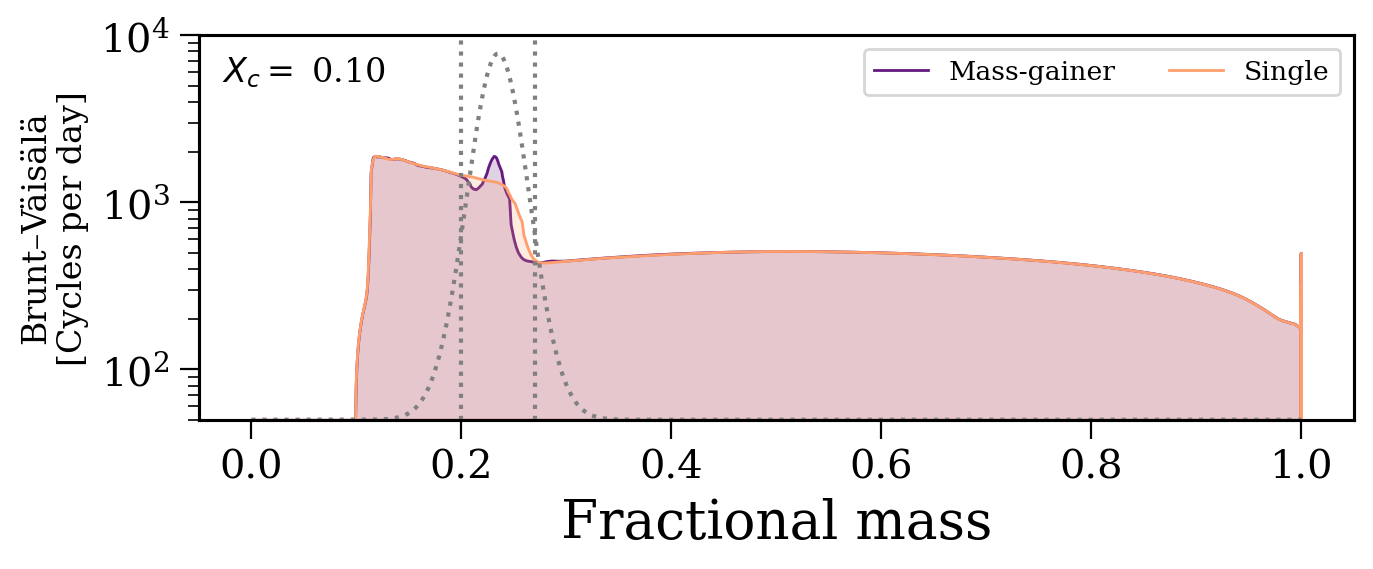

In [8]:
fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=[tracks["mg"][1], tracks["sing"]], fractional_mass=True, show=False, label_with="an")

ax_right = ax.twinx()

ax_right.plot(np.linspace(0, 1, 10000), norm(0.235, 0.03).pdf(np.linspace(0, 1, 10000)), color="grey", linestyle="dotted")
ax_right.set_ylim(bottom=0.0)
ax_right.set_yticks([])

for dm in [0.2, 0.27]:
    ax_right.axvline(dm, color="grey", linestyle="dotted")

ax.set_xlabel("Fractional mass")


plt.show()

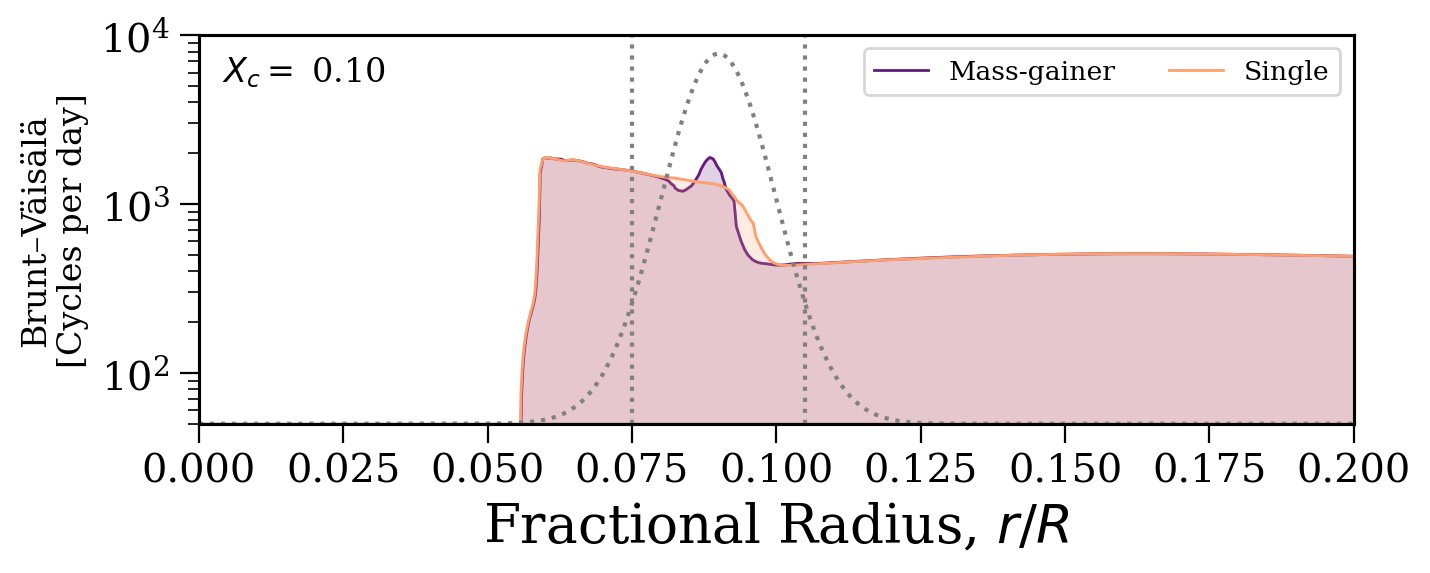

In [19]:
fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=[tracks["mg"][1], tracks["sing"]], fractional_radius=True, show=False, label_with="an")

ax_right = ax.twinx()

ax_right.plot(np.linspace(0, 1, 10000), norm(0.09, 0.01).pdf(np.linspace(0, 1, 10000)), color="grey", linestyle="dotted")
ax_right.set_ylim(bottom=0.0)
ax_right.set_yticks([])

for dm in [0.075, 0.105]:
    ax_right.axvline(dm, color="grey", linestyle="dotted")

ax.set_xlim(0, 0.2)

plt.show()

(0.5, 4.183179117584783)

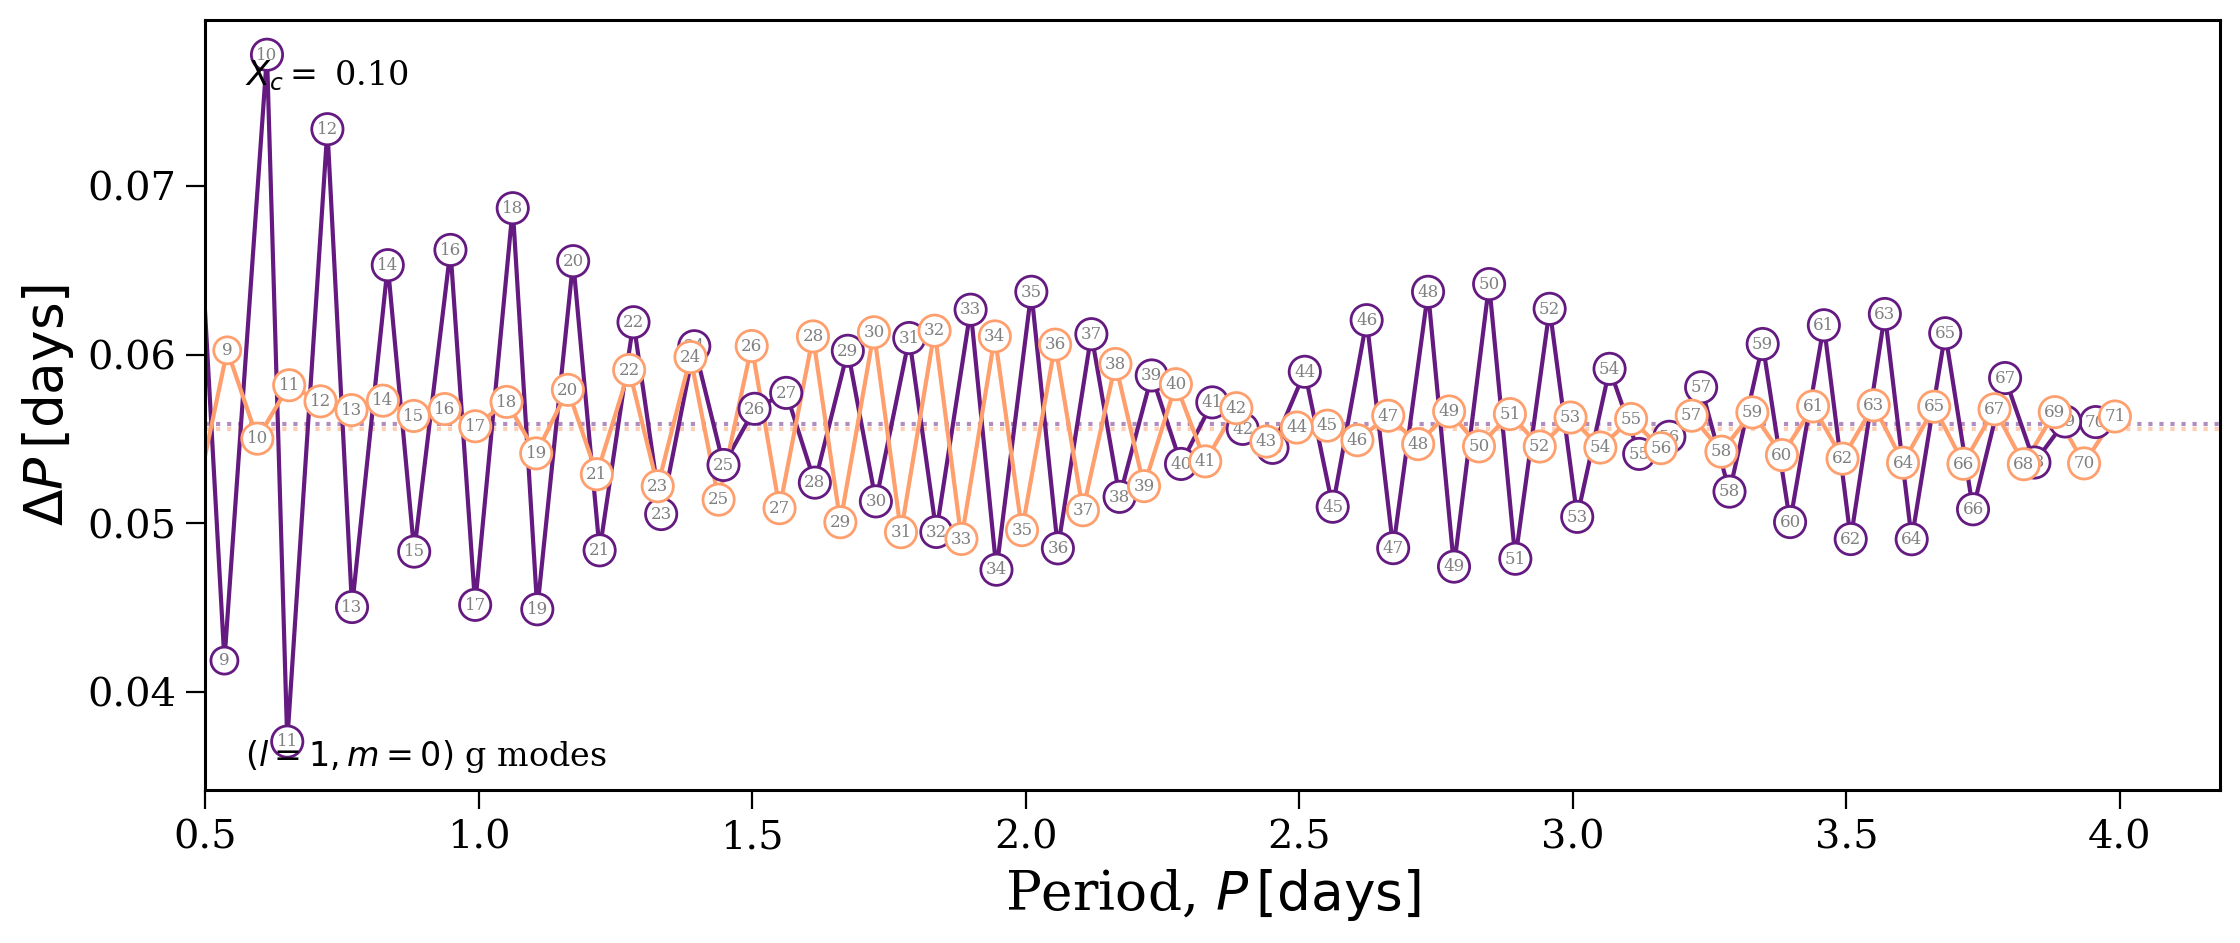

In [128]:
fig, ax = plt.subplots(figsize=(13, 5))
mpt.plot_period_spacing(X_c=0.1, tracks=[tracks["mg"][1], tracks["sing"]], label_modes=True, fig=fig, ax=ax, show=False)
ax.get_legend().remove()
ax.set_xlim(left=0.5)

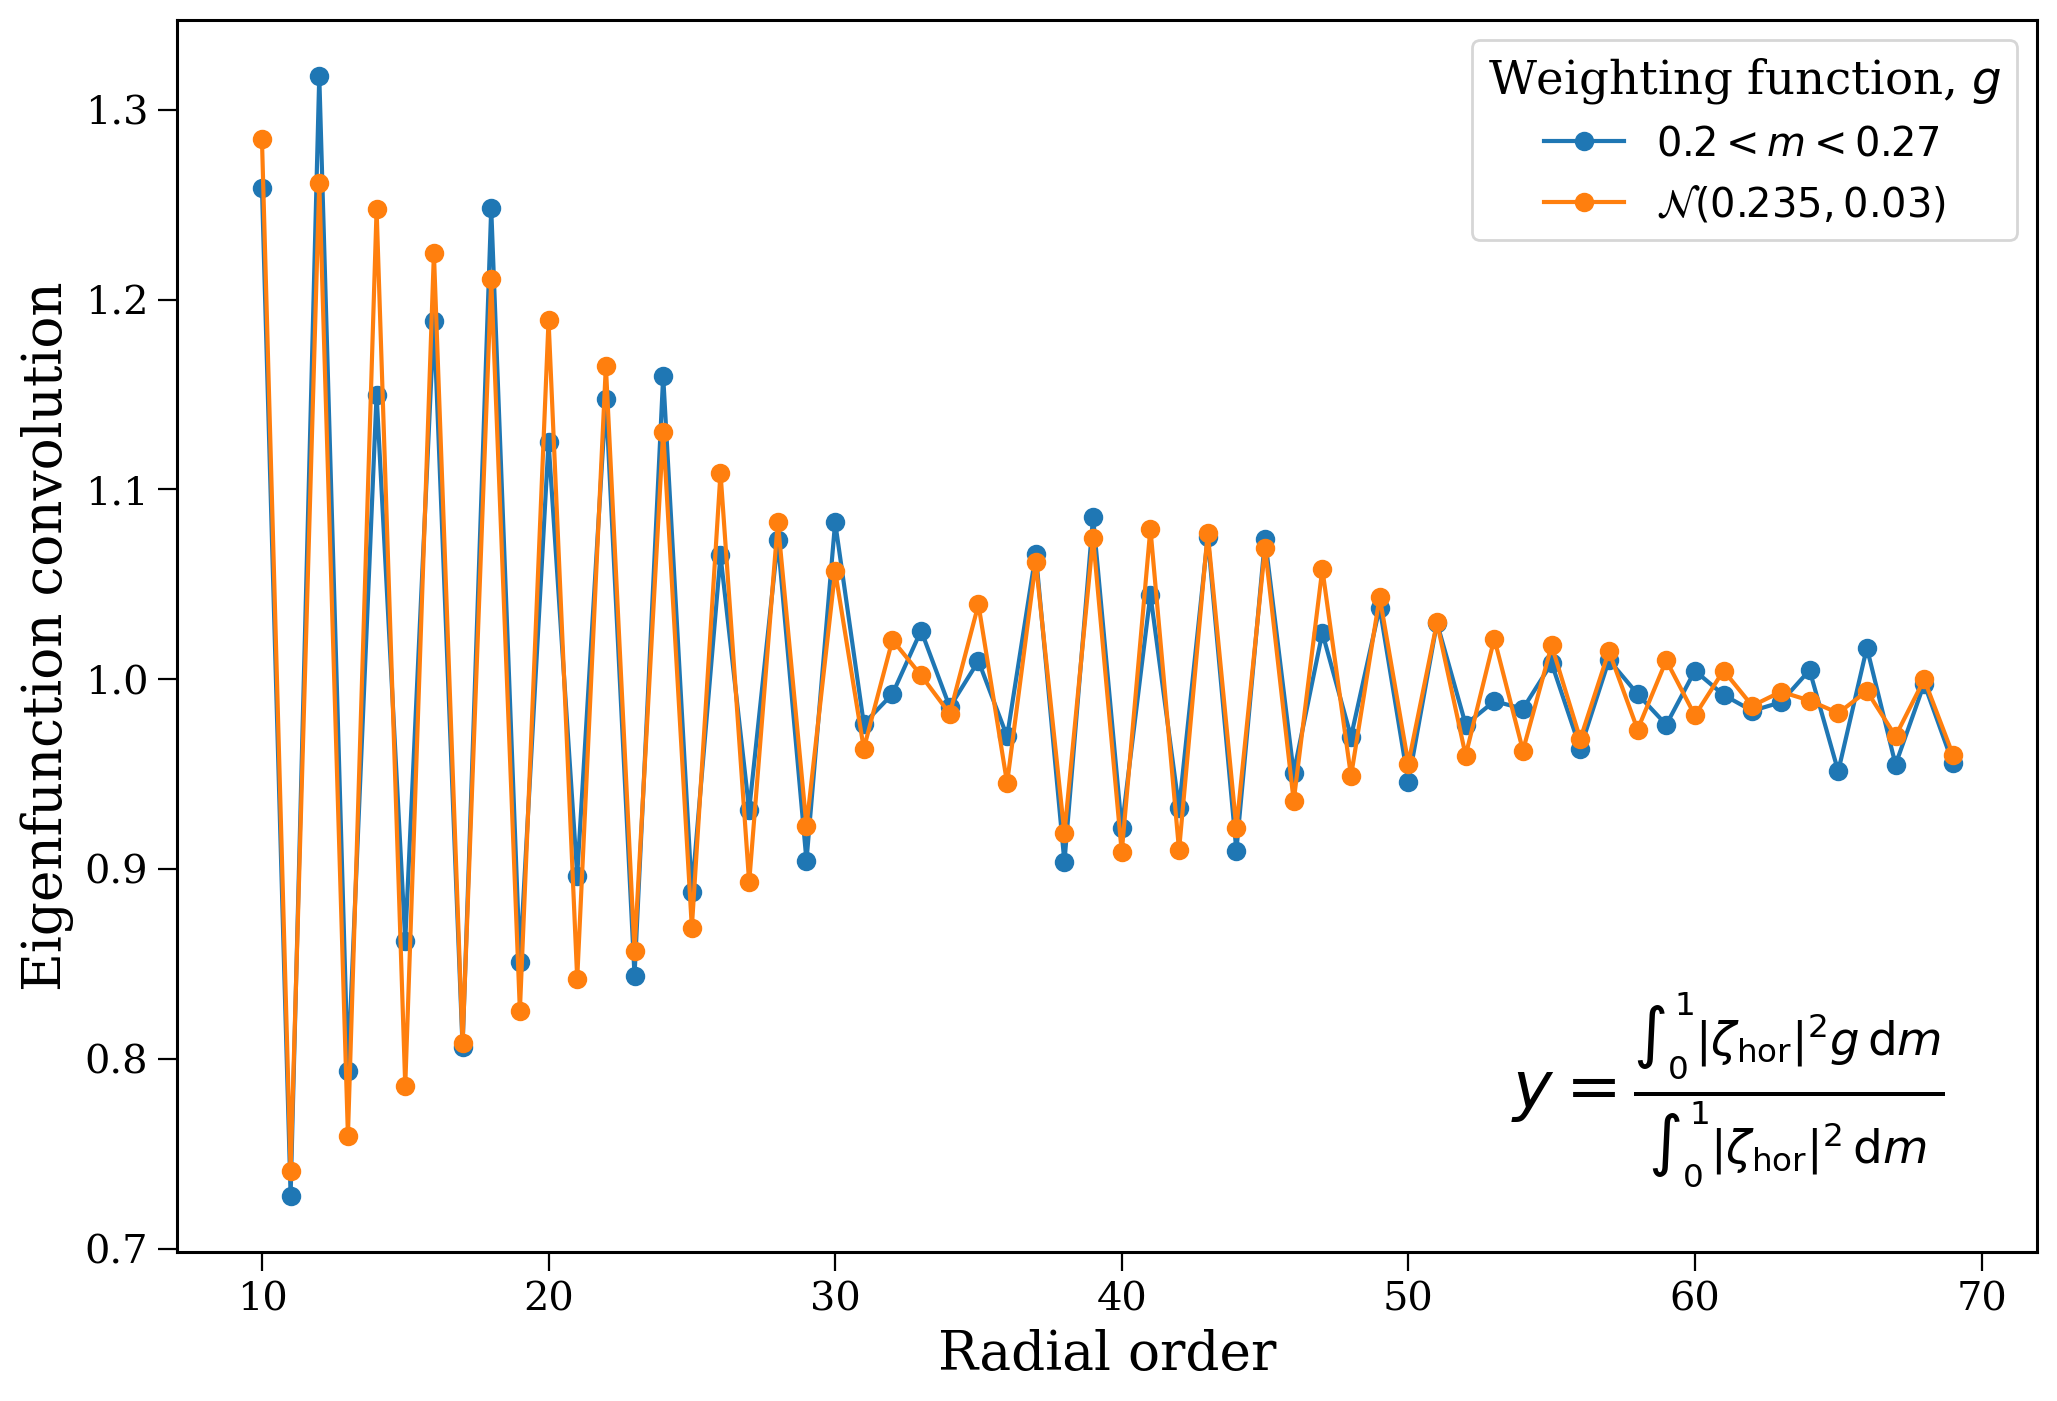

In [147]:
for w, m, c, l in zip([np.vectorize(lambda x: int(0.2 < x < 0.27)), norm(0.235, 0.03).pdf],
                   ['o', 'o', 'o'], [None, None, None], [r"$0.2 < m < 0.27$", r"$\mathcal{N}(0.235, 0.03)$", r"$x$"]):
    n_range, trappings = get_trappings(tracks["sing"], X_c=0.1, weight_function=w)
    plt.plot(n_range, trappings / trappings.mean(), marker=m, color=c, label=l)
leg = plt.legend(title=r"Weighting function, $g$")
leg.get_title().set_fontsize(0.7*fs)

plt.annotate(r"$y = \frac{ \int_0^1 |\zeta_{\rm hor}|^2 g \, \mathrm{d}m }{ \int_0^1 |\zeta_{\rm hor}|^2  \, \mathrm{d}m }$",
             xy=(0.95, 0.05), xycoords="axes fraction", ha="right", va="bottom", fontsize=fs)

plt.xlabel("Radial order")
plt.ylabel("Eigenfunction convolution")

plt.show()

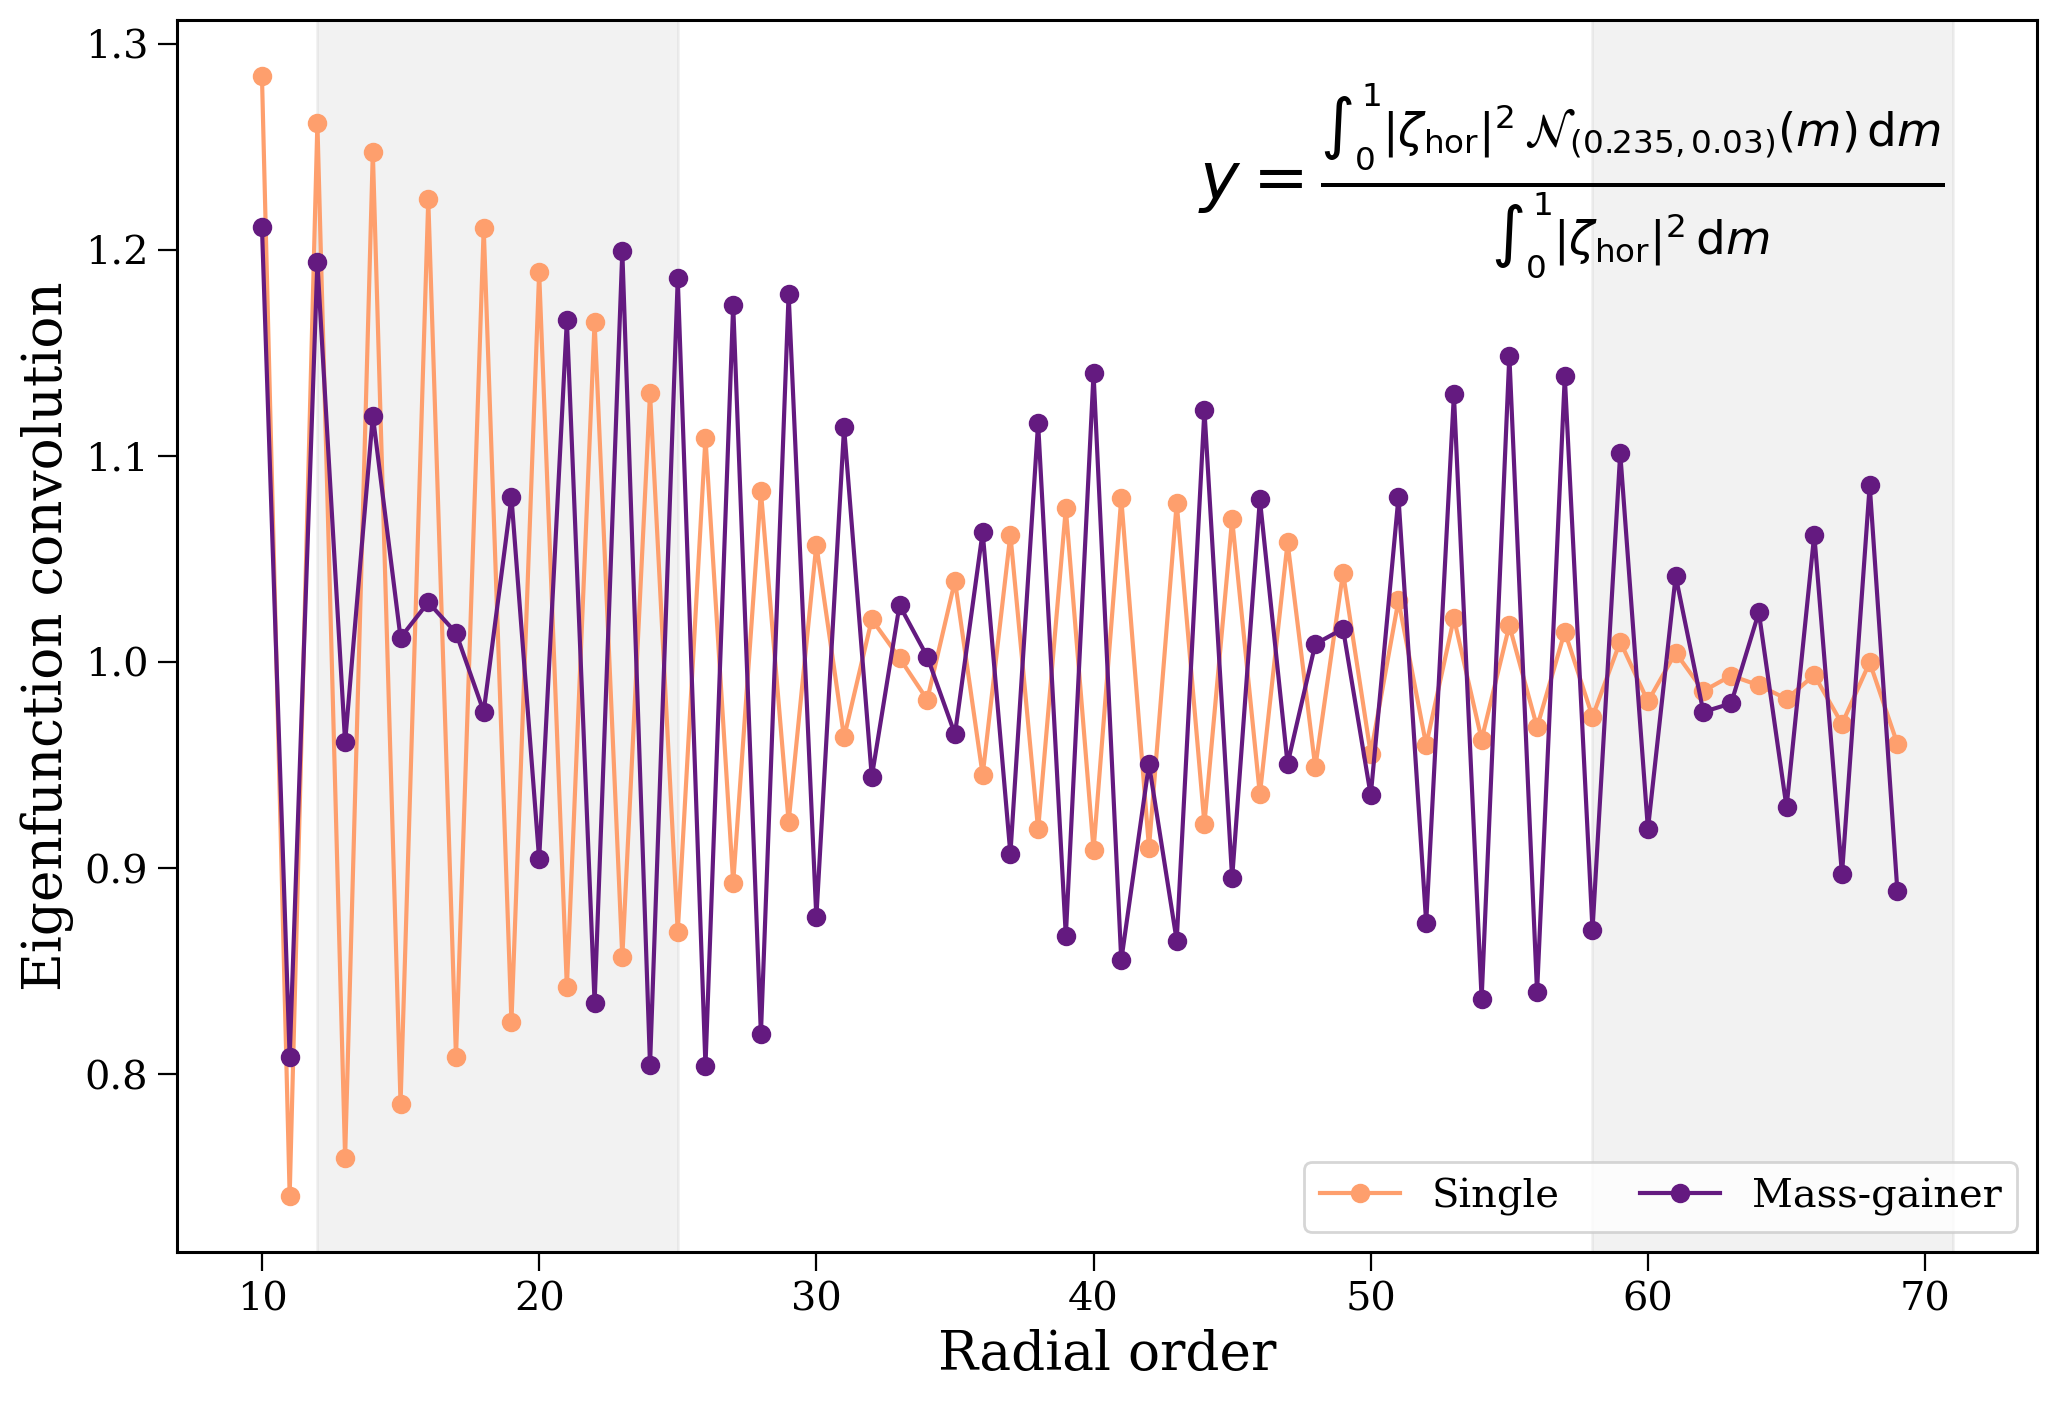

In [148]:
for t, w, m, c, l in zip([tracks["sing"], tracks["mg"][1]], [norm(0.235, 0.03).pdf, norm(0.235, 0.03).pdf], ['o', 'o'], [mpt.single_col, mpt.mass_gainer_col], ["Single", "Mass-gainer"]):
    n_range, trappings = get_trappings(t, X_c=0.1, weight_function=w)
    plt.plot(n_range, trappings / trappings.mean(), marker=m, color=c, label=l)

plt.legend(loc="lower right", ncol=2)

plt.annotate(r"$y = \frac{ \int_0^1 |\zeta_{\rm hor}|^2 \, \mathcal{N}_{(0.235, 0.03)}(m) \, \mathrm{d}m }{ \int_0^1 |\zeta_{\rm hor}|^2  \, \mathrm{d}m }$",
             xy=(0.95, 0.95), xycoords="axes fraction", ha="right", va="top", fontsize=fs)

plt.axvspan(12, 25, color="grey", alpha=0.1, zorder=-1)
plt.axvspan(58, 71, color="grey", alpha=0.1, zorder=-1)


plt.xlabel("Radial order")
plt.ylabel("Eigenfunction convolution")

plt.show()

In [49]:
def get_trappings(track, X_c, weight_function=norm(0.235, 0.01).pdf, n_min=10, n_max=70, use_dx=False, m_max=0.99):
    n_range = range(n_min, n_max)
    trappings = np.asarray([None for _ in n_range])
    eigs = mpt.get_eigenfunctions(track=track, profile_number=mpt.find_closest_model_number(track=track, X_c=X_c))

    prof = track.profiles[mpt.find_closest_model_number(track=track, X_c=X_c) - 1]
    N_func = interp1d(10**(prof["logR"]) / 10**(prof["logR"].max()), prof["brunt_N"].values, fill_value="extrapolate")
    for i, n in enumerate(n_range):
        sph_deg = 1
        rad_ord = -n
        x = eigs[(sph_deg, 'x')]
        m = eigs[(1, "M_r")] / eigs[(1, "M_r")].max()
        hor = eigs[(sph_deg, rad_ord)]['Re(xi_h)']

        mask = (m > 0) & (m < m_max)
        hor, m, x = hor[mask], m[mask], x[mask]
        N = N_func(x)

        if weight_function == "x":
            g = x
        else:
            g = weight_function(m) if use_dx is False else weight_function(x)

        trappings[i] = np.trapz(y=hor / x * N * g, x=x if use_dx else m) / np.trapz(y=hor / x * N, x=x if use_dx else m)

    return n_range, trappings

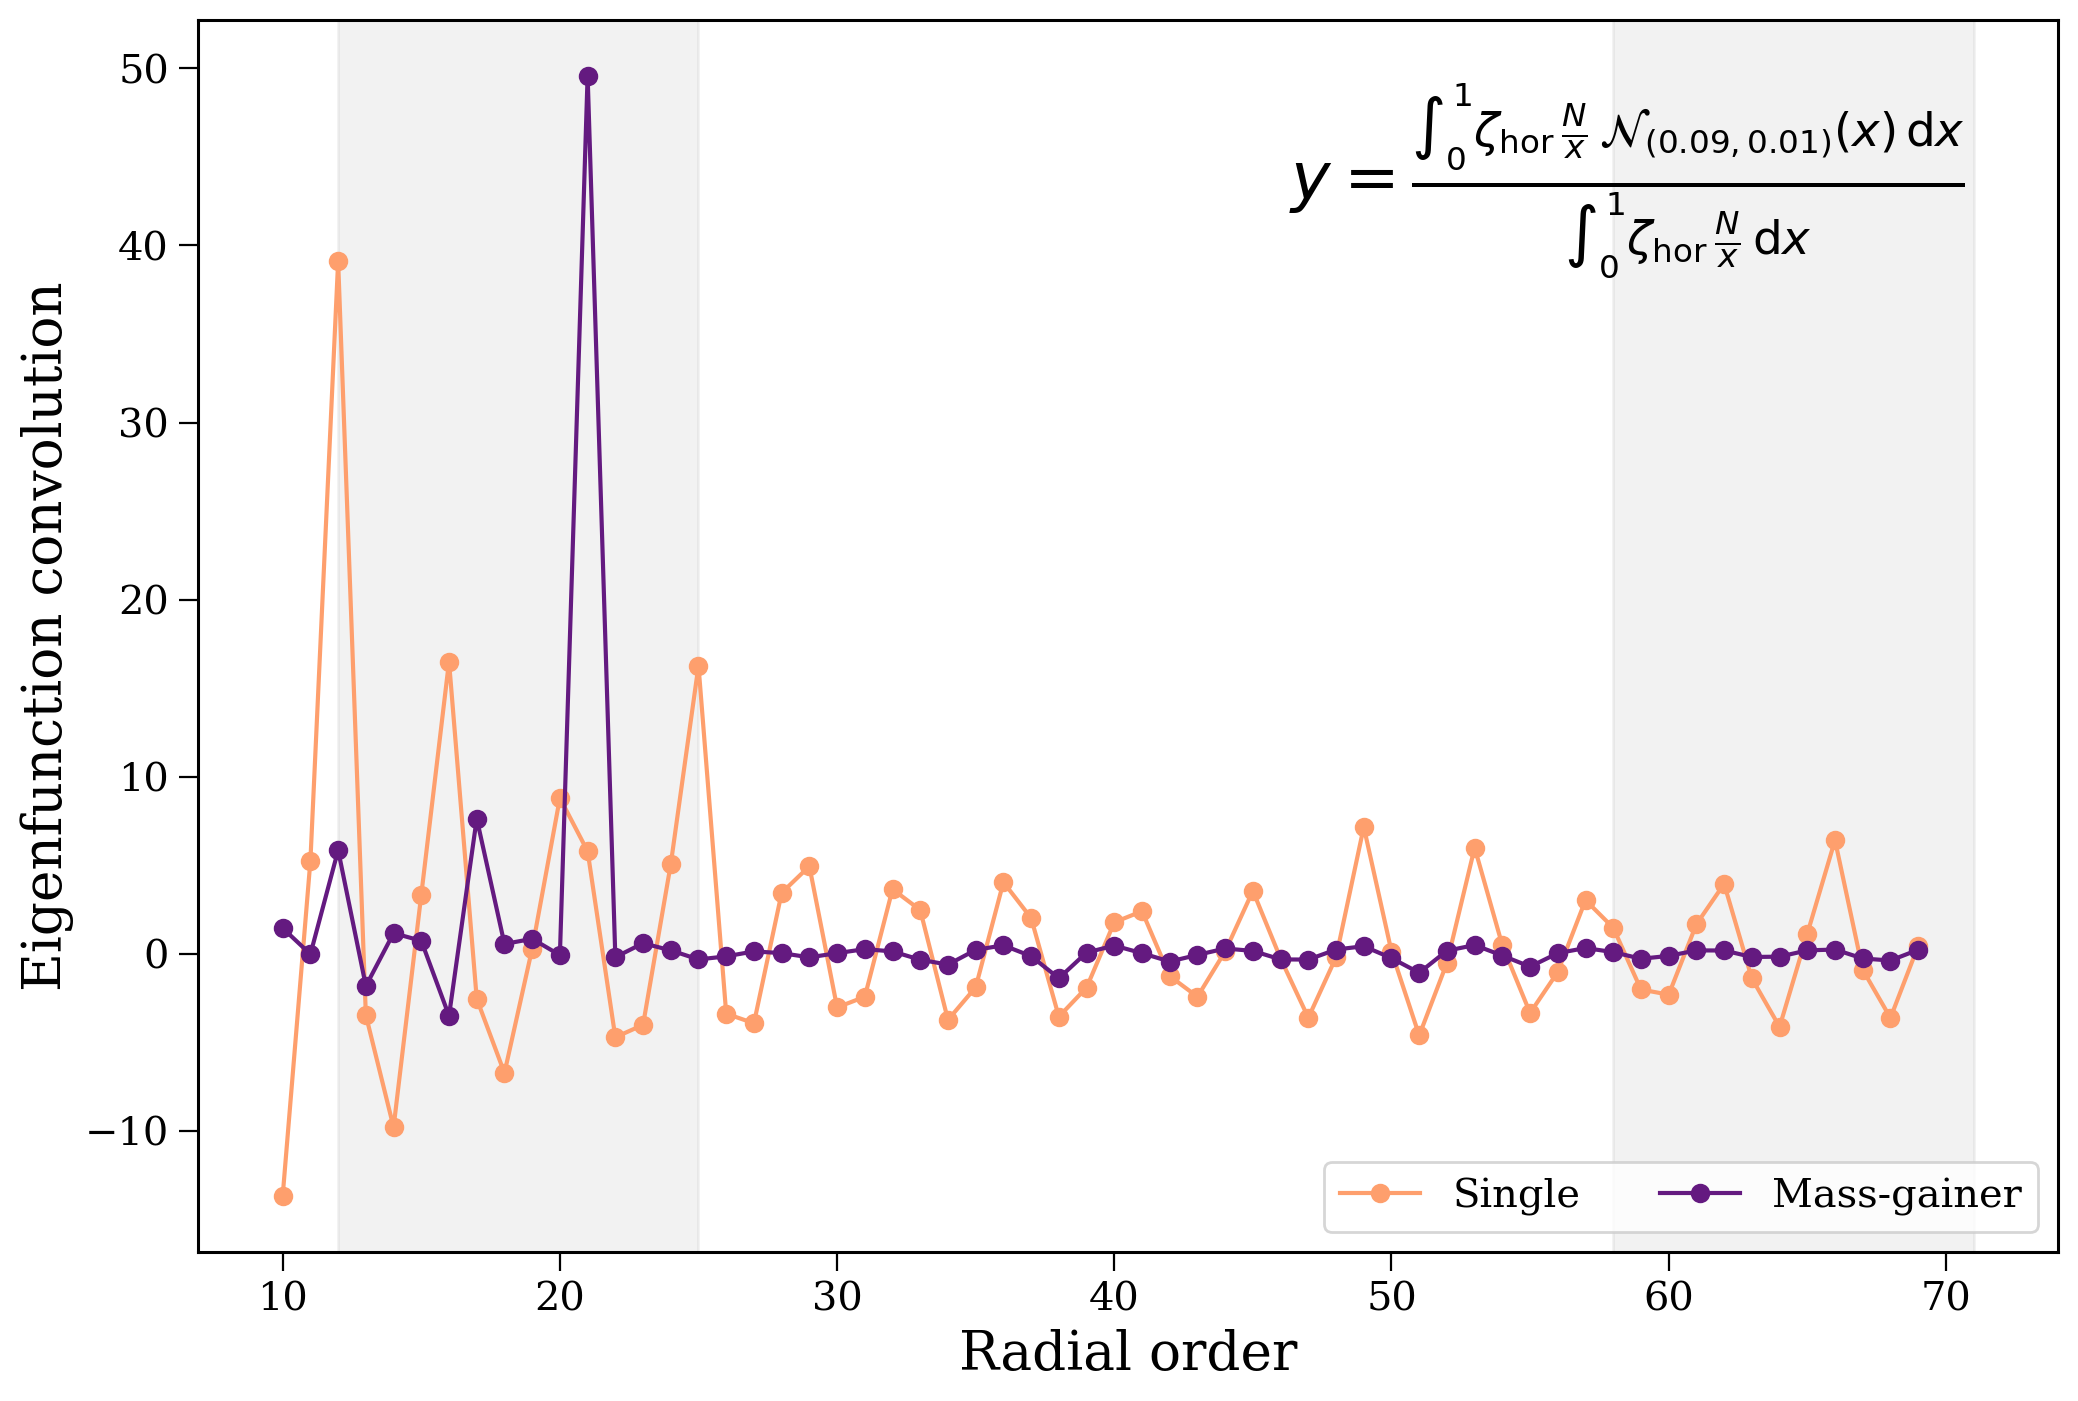

In [53]:
for t, w, m, c, l in zip([tracks["sing"], tracks["mg"][1]], [norm(0.09, 0.01).pdf, norm(0.09, 0.01).pdf], ['o', 'o'], [mpt.single_col, mpt.mass_gainer_col], ["Single", "Mass-gainer"]):
    n_range, trappings = get_trappings(t, X_c=0.1, weight_function=w, use_dx=True)
    plt.plot(n_range, trappings / trappings.mean(), marker=m, color=c, label=l)

plt.legend(loc="lower right", ncol=2)

plt.annotate(r"$y = \frac{ \int_0^1 \zeta_{\rm hor} \, \frac{N}{x} \, \mathcal{N}_{(0.09, 0.01)}(x) \, \mathrm{d}x }{ \int_0^1 \zeta_{\rm hor} \, \frac{N}{x} \, \mathrm{d}x }$",
             xy=(0.95, 0.95), xycoords="axes fraction", ha="right", va="top", fontsize=fs)

plt.axvspan(12, 25, color="grey", alpha=0.1, zorder=-1)
plt.axvspan(58, 71, color="grey", alpha=0.1, zorder=-1)


plt.xlabel("Radial order")
plt.ylabel("Eigenfunction convolution")

# plt.yscale("log")

plt.show()

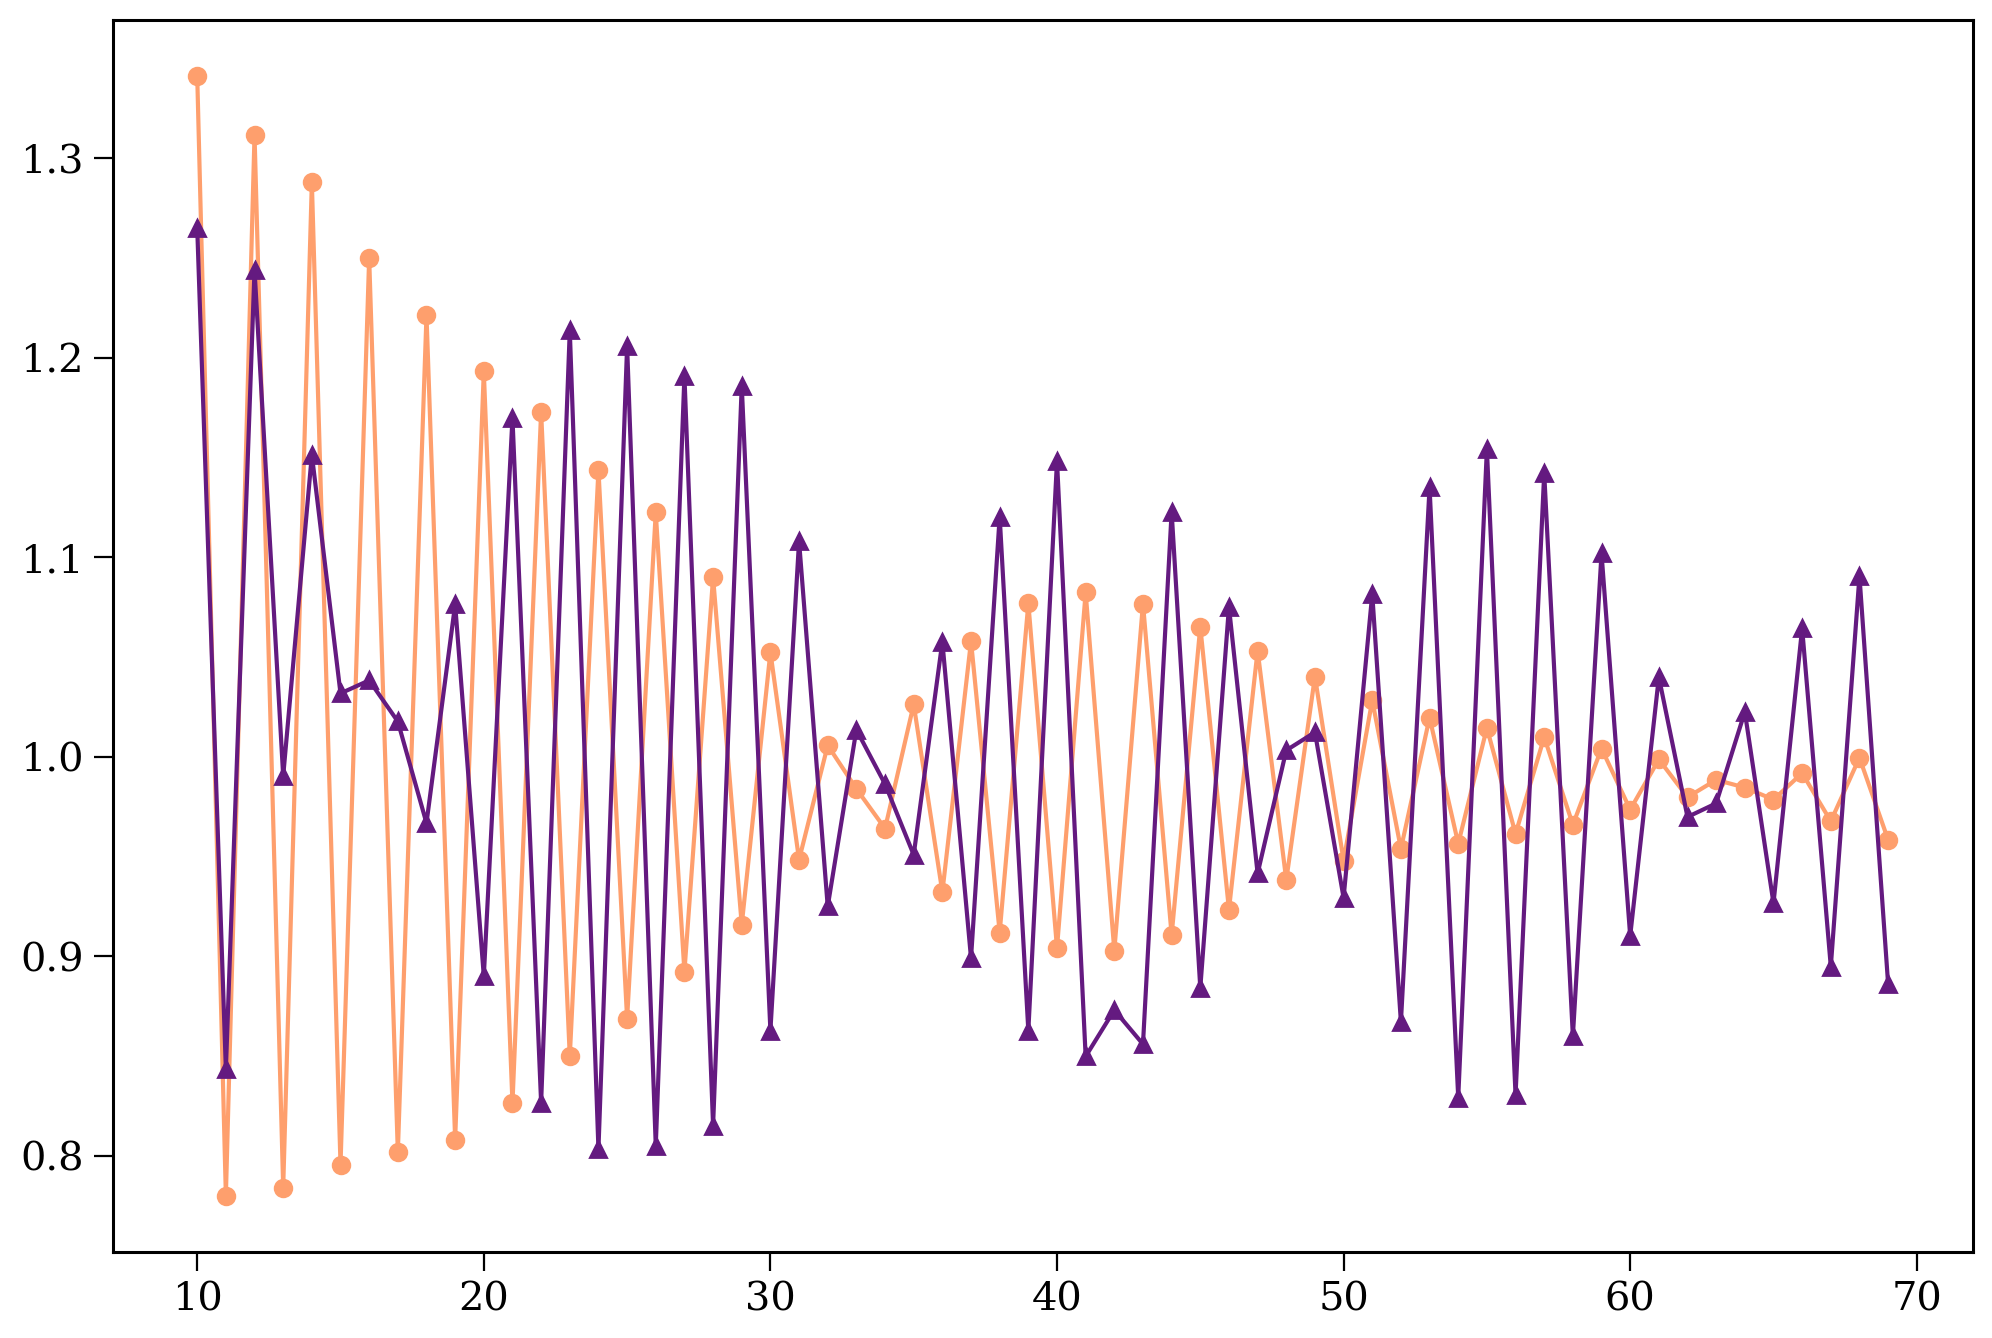

In [130]:
for t, w, m, c in zip([tracks["sing"], tracks["mg"][1]], [norm(0.235, 0.03).pdf, norm(0.235, 0.03).pdf], ['o', '^'], [mpt.single_col, mpt.mass_gainer_col]):
    n_range, trappings = get_trappings(t, X_c=0.1, weight_function=w)
    plt.plot(n_range, trappings / trappings.mean(), marker=m, color=c)

## Eigenfunctions

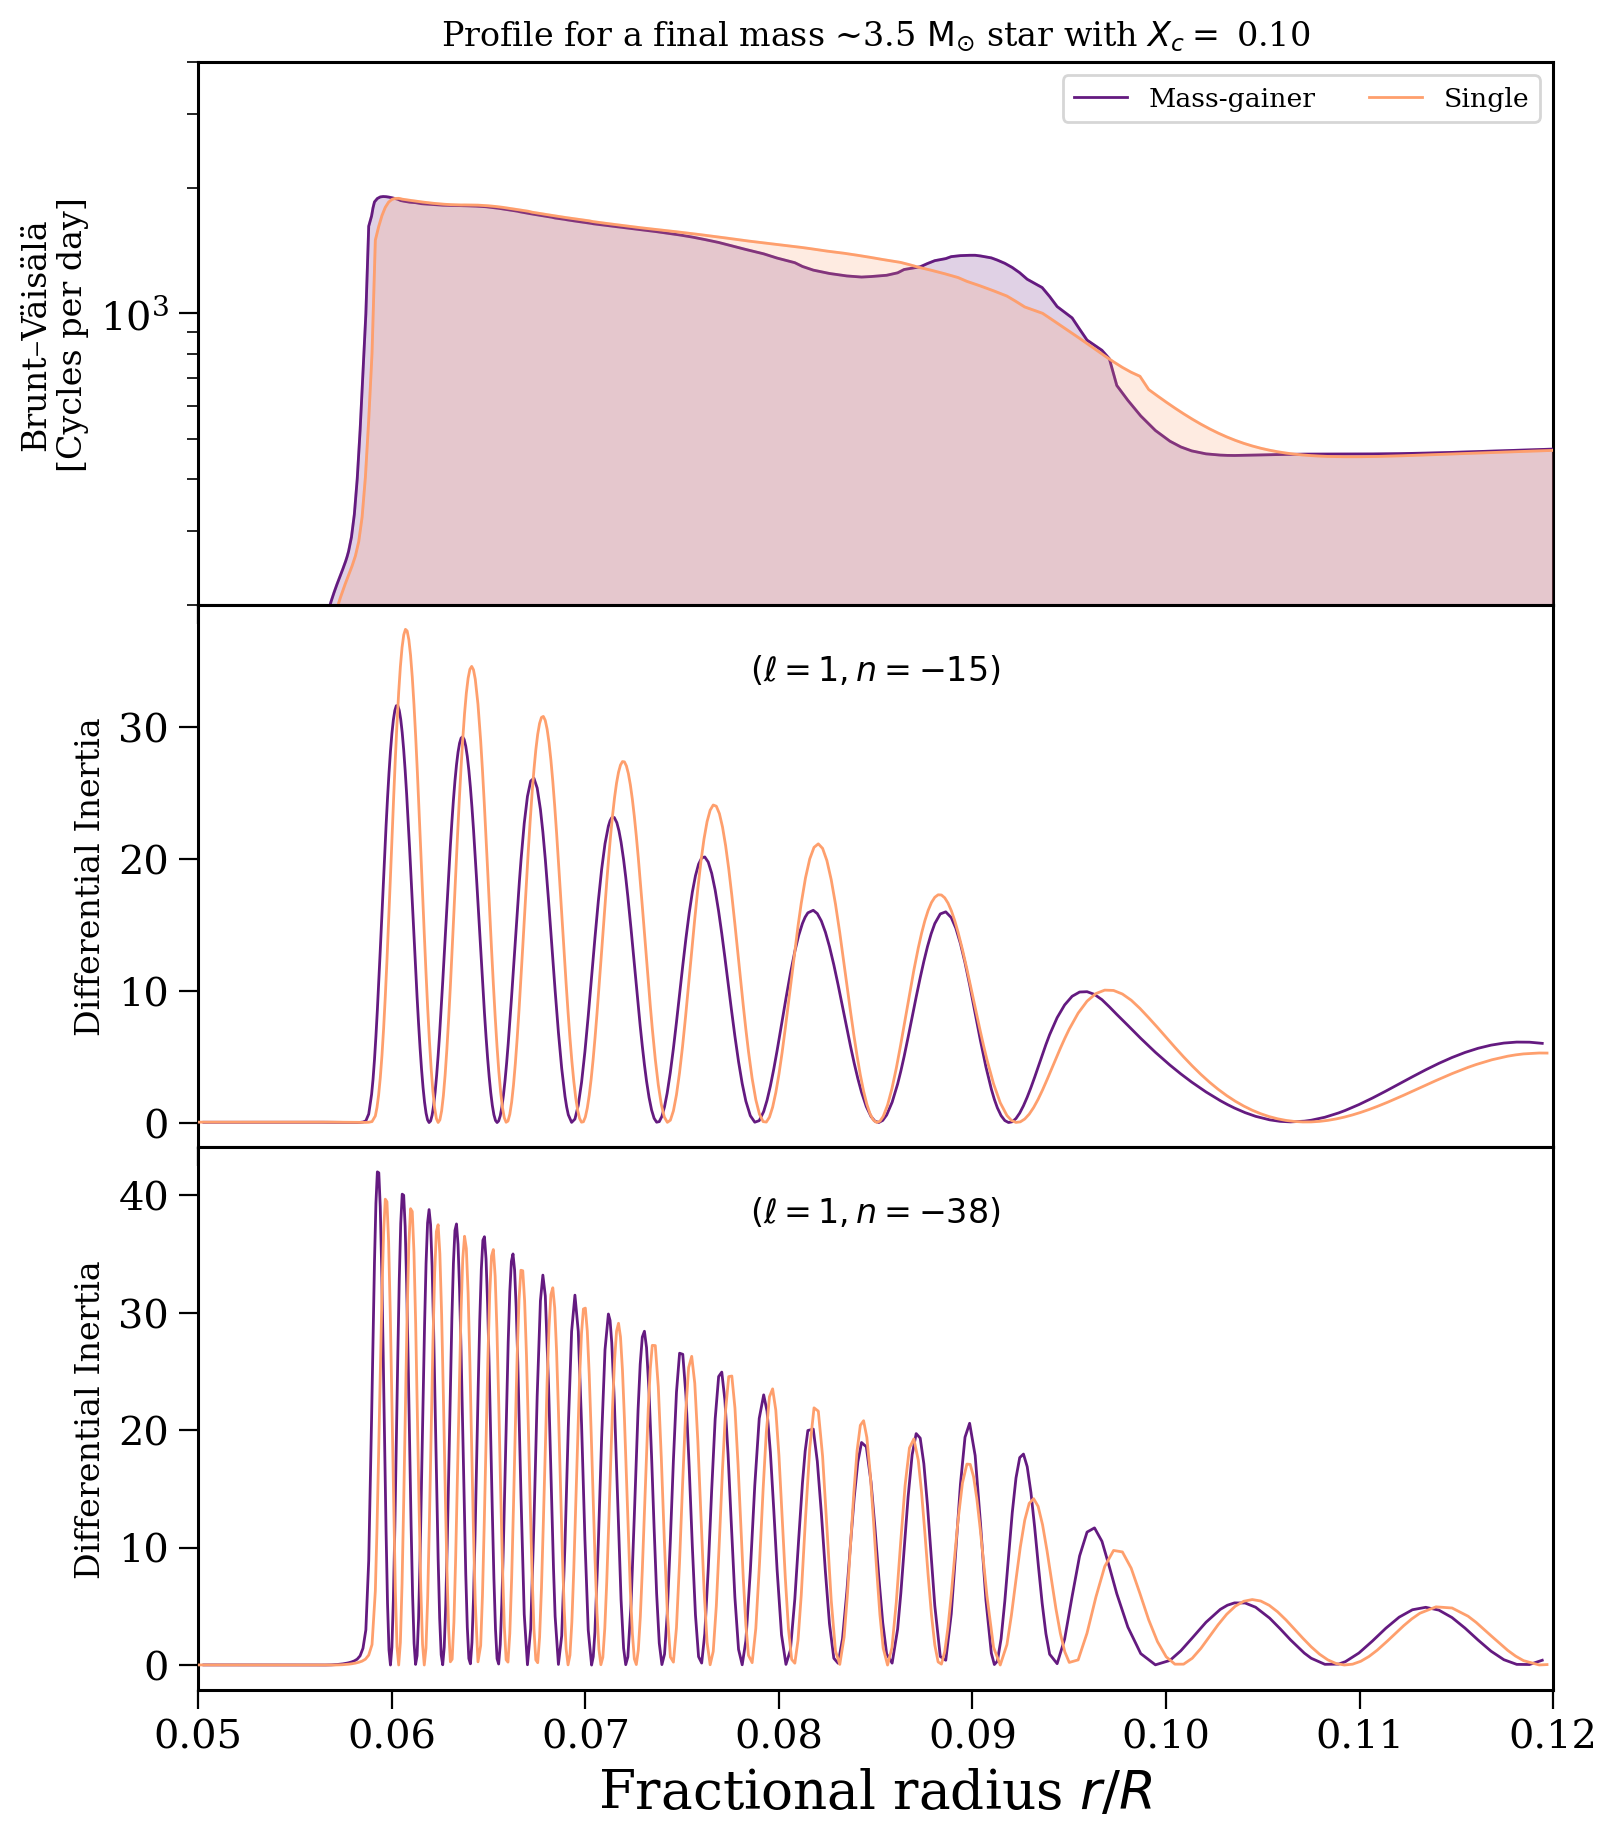

In [111]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

X_c = 0.1
x_range = (0.05, 0.12)

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], which="enorm", sph_deg=1, rad_ord=[-15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], which="enorm", sph_deg=1, rad_ord=[-38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 4e3)

plt.show()

In [61]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

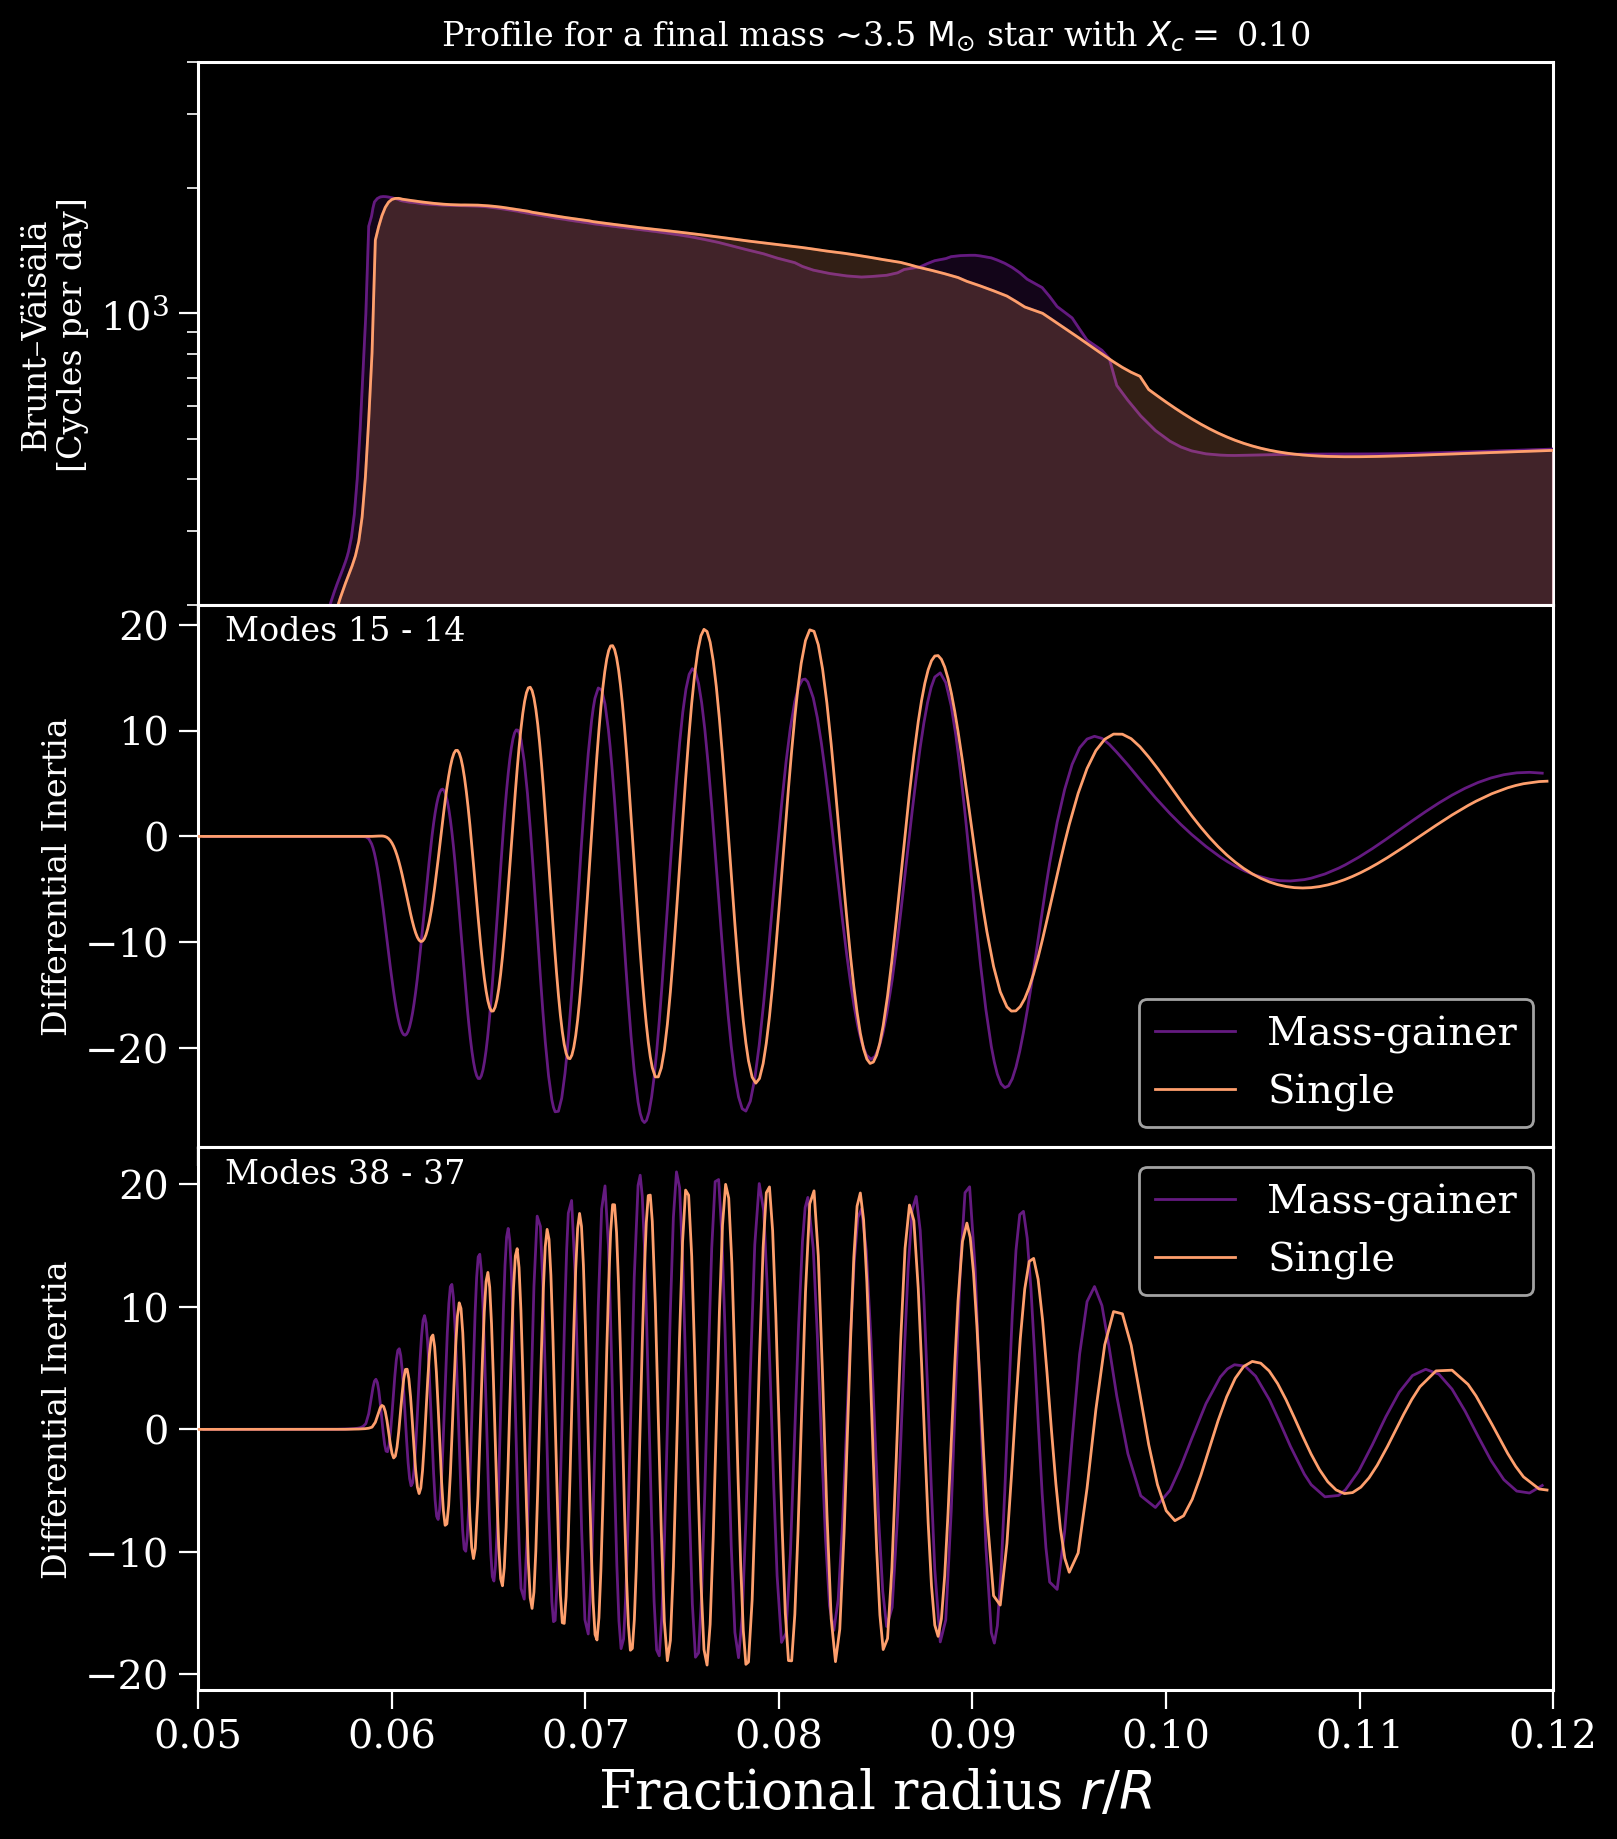

In [104]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

X_c = 0.1
x_range = (0.05, 0.12)

which = "enorm"

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which=which, sph_deg=1, rad_ord=[-14, -15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False, difference=True)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which=which, sph_deg=1, rad_ord=[-37, -38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False, difference=True)
mpt.plot_eigs(tracks=[single_tracks["M_3.5"]], which=which, sph_deg=1, rad_ord=[-14, -15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False,
              colours=[mpt.single_col, mpt.single_col], labels=["Single", "Single"], difference=True)
mpt.plot_eigs(tracks=[single_tracks["M_3.5"]], which=which, sph_deg=1, rad_ord=[-37, -38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False,
              colours=[mpt.single_col, mpt.single_col], labels=["Single", "Single"], difference=True)

axes[1].annotate("Modes 15 - 14", xy=(0.02, 0.98), ha="left", va="top", xycoords="axes fraction", fontsize=0.5*fs)
axes[2].annotate("Modes 38 - 37", xy=(0.02, 0.98), ha="left", va="top", xycoords="axes fraction", fontsize=0.5*fs)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 4e3)

plt.show()

In [328]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

"echo -n 'profile964.data.GYRE,profile980.data.GYRE,profile998.data.GYRE,profile1016.data.GYRE,profile1034.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [73]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

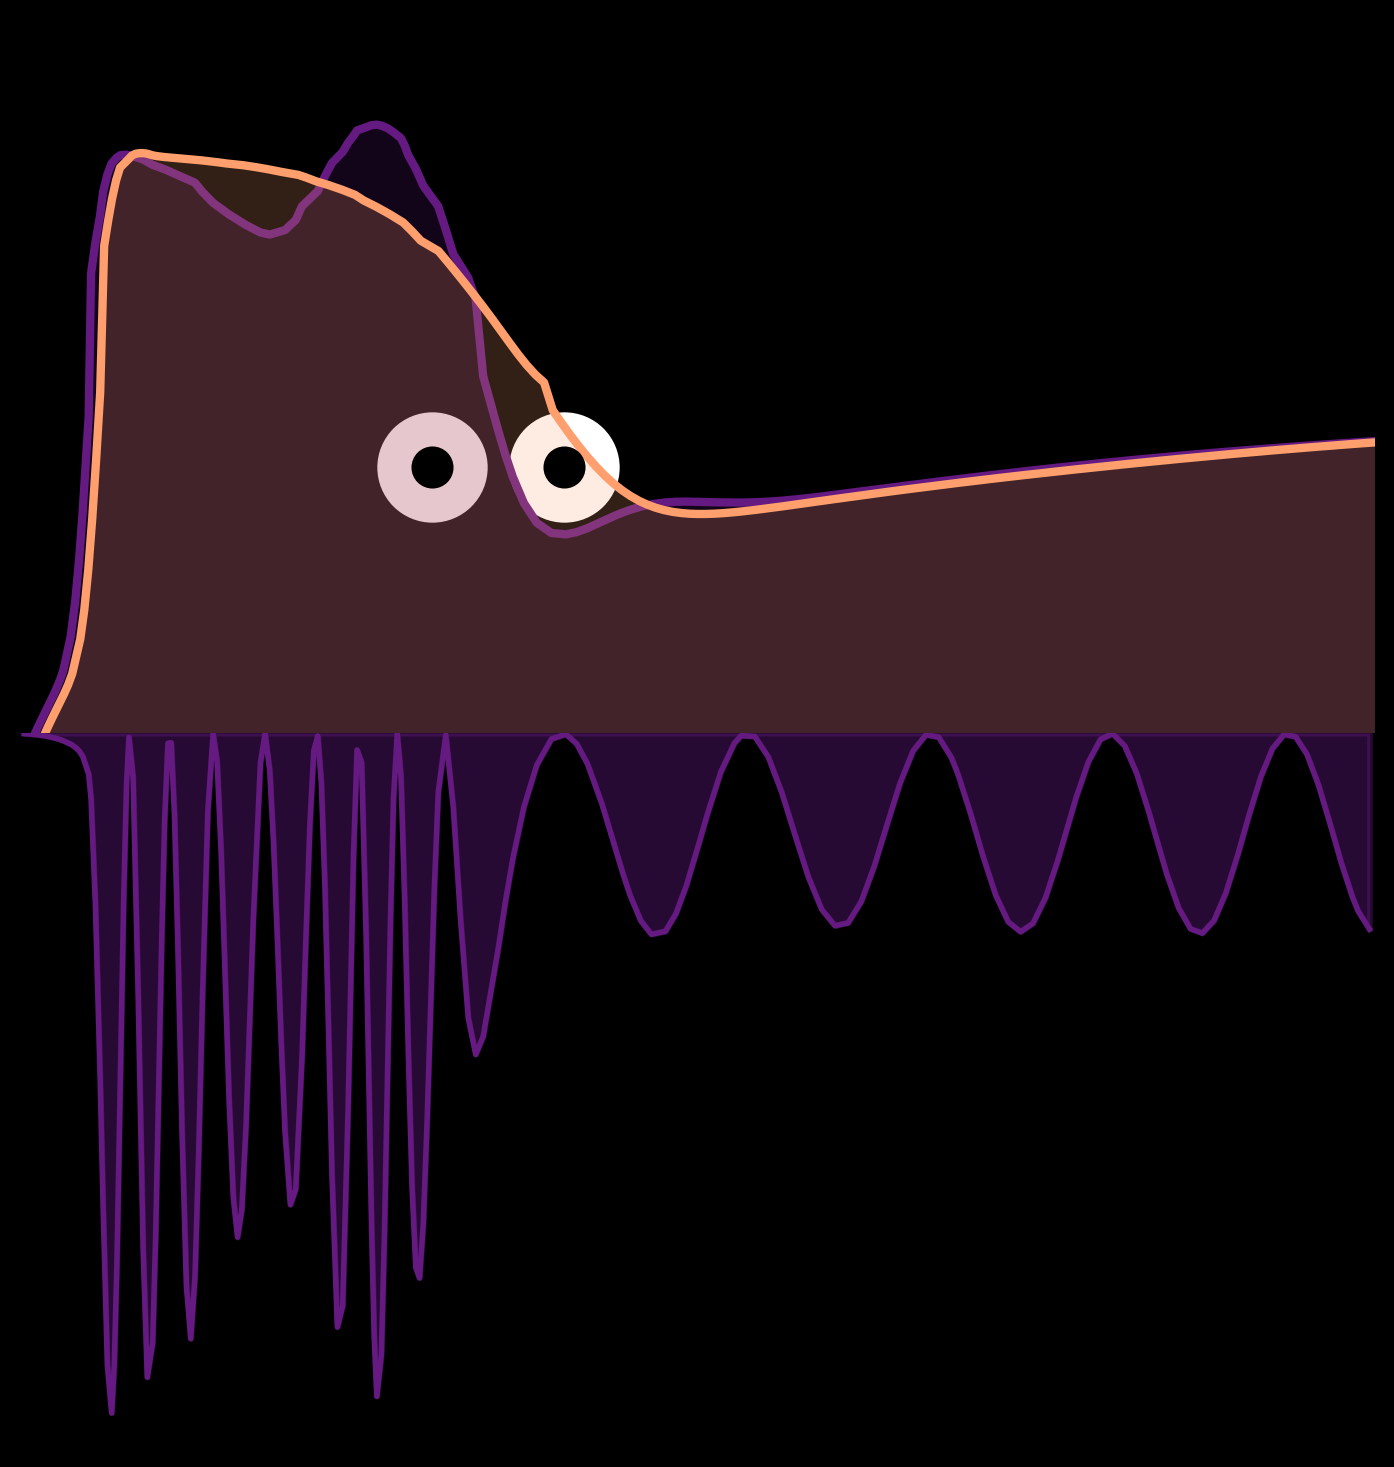

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

X_c = 0.4
x_range = (0.108, 0.18)

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False, lw=3)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which="enorm", sph_deg=1, rad_ord=[-40],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False, lw=2)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 3e3)
axes[0].set_title("")
axes[1].invert_yaxis()
axes[1].set_ylim(top=0.0)

for ax in axes:
    ax.axis("off")

def eyeball(x, y):
    axes[0].scatter(x, y, s=1500, color="white", zorder=3)
    axes[0].scatter(x, y, s=200, color="black", zorder=30)

eyeball(0.1369, 5.5e2)
eyeball(0.1299, 5.5e2)

plt.show()

## $\Pi_0$ plots (TODO)

In [ ]:
def append_pi_0(track):
    track.history.loc[:, "pi_0"] = [mpt.get_pi_0(track.profiles[i]) for i in range(len(track.profiles))]

In [ ]:
for track in single_tracks.values():
    append_pi_0(track)

In [ ]:
append_pi_0(tracks["4_3_5_mdm100"][1])

In [ ]:
colours = plt.get_cmap("binary_r")(np.linspace(0.1, 1, len(Ms)))

fig, axes = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={"width_ratios": [16, 1]})
fig.subplots_adjust(wspace=0.0)

ax, cbar_ax = axes

i = 0
for key, track in single_tracks.items():
    ax.plot(track.history["center_h1"], track.history["pi_0"], color=colours[i])
    i += 1

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"],
         tracks["4_3_5_mdm100"][1].history["pi_0"],
         color="tab:red", zorder=10, lw=2)



norm = mpl.colors.Normalize(vmin=min(Ms), vmax=max(Ms))

cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap="binary_r", norm=norm)
cb.ax.tick_params(labelsize=0.5*fs)
cb.set_label(f"Mass")

# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel("Central H abundance")
ax.set_ylabel(r"$\Pi_0\, [\rm s]$")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for key, track in single_tracks.items():
    ax.plot(track.history["center_h1"], track.history["pi_0"], color="lightgrey", lw=0.5)

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"],
         tracks["4_3_5_mdm100"][1].history["pi_0"],
         color="tab:red", zorder=10, lw=1, label="Mass-gainer")

ax.plot(single_tracks["M_3.0"].history["center_h1"], single_tracks["M_3.0"].history["pi_0"], color="grey", lw=0.5)
ax.plot(single_tracks["M_3.5"].history["center_h1"], single_tracks["M_3.5"].history["pi_0"], color="grey", lw=0.5, label="Single star (3.0 and 3.5)")

ax.plot(track.history["center_h1"], track.history["pi_0"], color="lightgrey", lw=0.5, label="Other single stars")

ax.legend()


# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel(r"Central H abundance, $X_c$")
ax.set_ylabel(r"$\Pi_0\, [\rm s]$")

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
h1_to_pi0 = interp1d(single_tracks["M_3.5"].history["center_h1"], single_tracks["M_3.5"].history["pi_0"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ratio = tracks["4_3_5_mdm100"][1].history["pi_0"] / h1_to_pi0(tracks["4_3_5_mdm100"][1].history["center_h1"])

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"], ratio)
ax.axhline(1.0, linestyle="dotted", color="lightgrey")


# ax.set_yscale("log")
# ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel(r"Central H abundance, $X_c$")
ax.set_ylabel(r"$\Pi_0 ({\rm binary}) / \Pi_0 ({\rm single 3.5})$")

In [ ]:
pi_0 = [mpt.get_pi_0(single_tracks["M_3.0"].profiles[i]) for i in range(len(single_tracks["M_3.0"].profiles))]

# Appendix: `min_D_mix`

Here we explore how changing `min_D_mix` affects our results

# Brunt-Vaisala Comparison

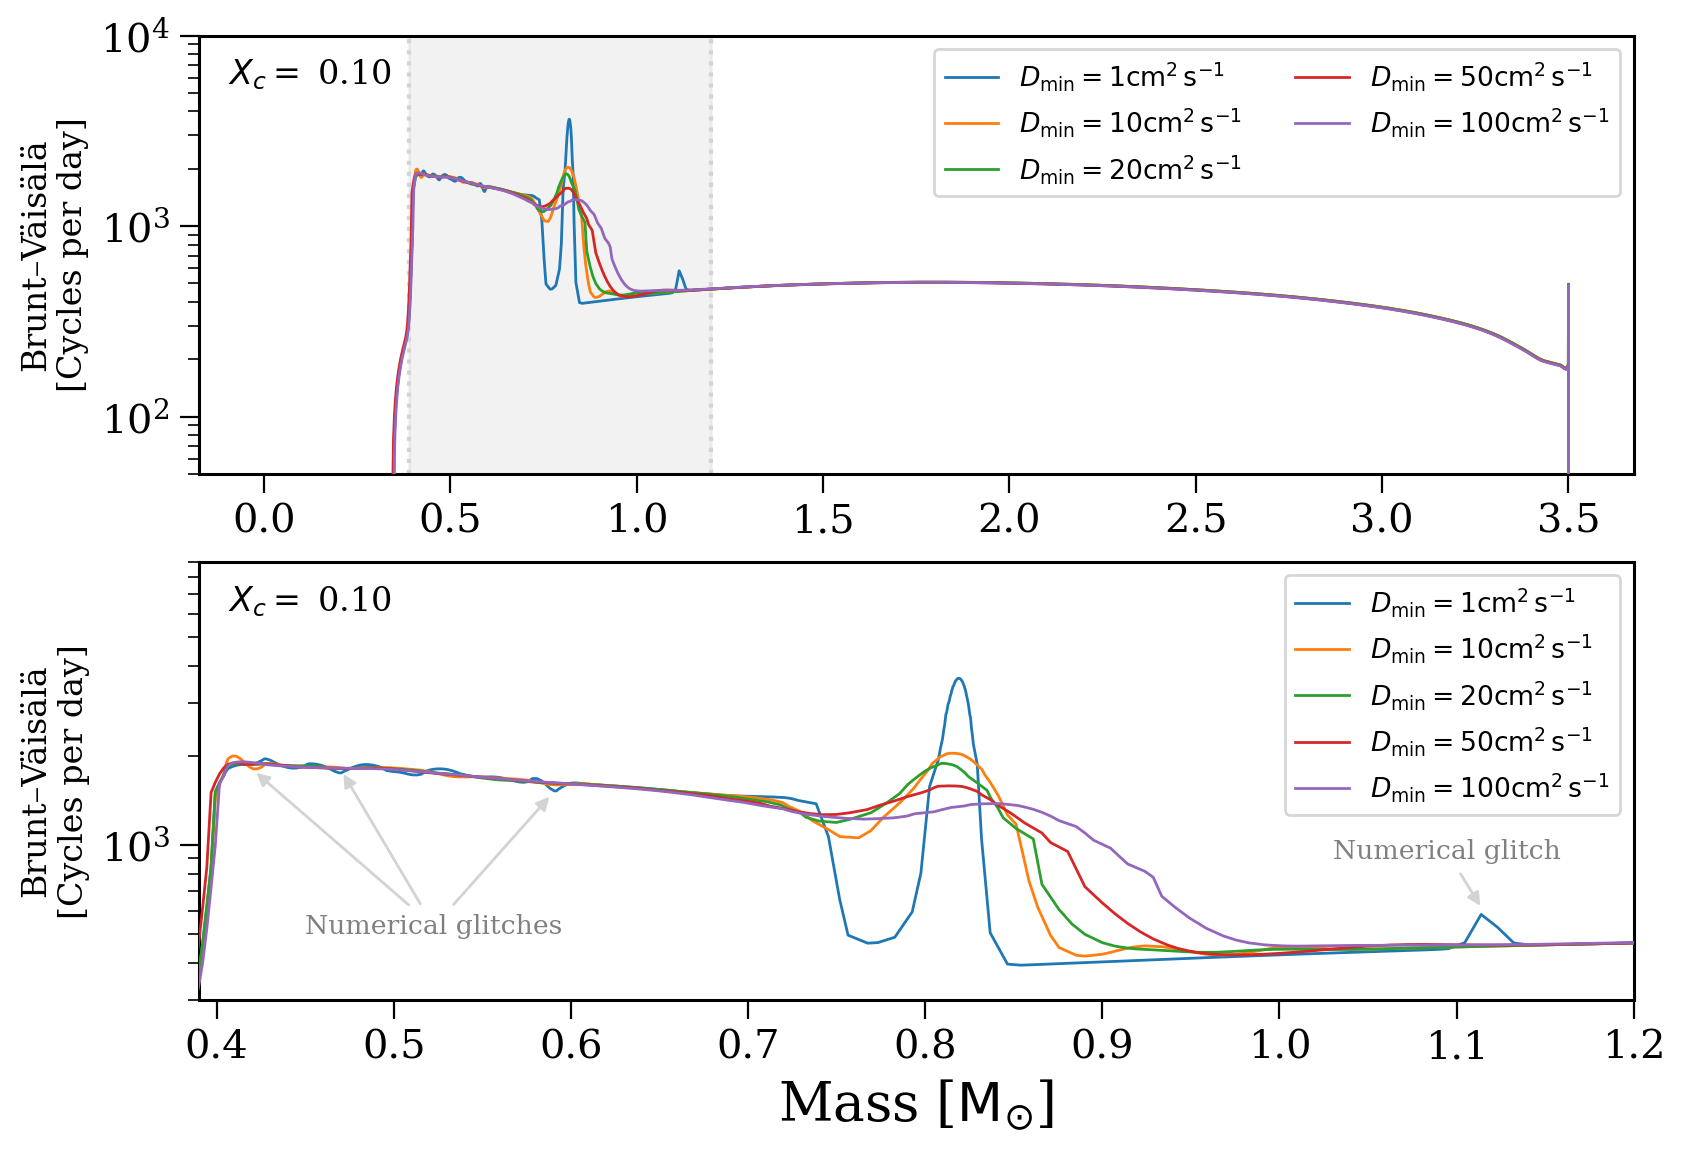

In [336]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6.5))

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["4_3_5_mdm100"][1], tracks["4_3_5_mdm50"][1],
                                                    D_mix_tracks["D_20"][1],
                                                    tracks["4_3_5_mdm10"][1], tracks["4_3_5_mdm1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[0])

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["4_3_5_mdm100"][1], tracks["4_3_5_mdm50"][1],
                                                    D_mix_tracks["D_20"][1],
                                                    tracks["4_3_5_mdm10"][1], tracks["4_3_5_mdm1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[1], legend_loc="upper right")

ax.get_legend().remove()
ax.legend(ncol=1, fontsize=0.4*fs)

fig.subplots_adjust(hspace=0.2)

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

axes[1].set_xlim(0.39, 1.2)
axes[1].set_ylim(bottom=3e2, top=9e3)

def add_arrow(ax, text, start, end, hide_text=False):
    ax.annotate(text, xytext=start, xy=end,
                 arrowprops=dict(arrowstyle="-|>", color="lightgrey"),
                 color="grey" if not hide_text else "white", zorder=10, fontsize=0.4*fs)

add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.47, 1.8e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.59, 1.5e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.42, 1.8e3))


add_arrow(axes[1], "Numerical glitch", (1.03, 9e2), (1.115, 6e2))

# plt.savefig("figures/min_D_mix_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

Parsing $m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 10 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:05<00:00, 181.31it/s]


Parsing $D_{\rm min} = 15 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:09<00:00, 106.20it/s]


Parsing $D_{\rm min} = 20 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:05<00:00, 176.51it/s]


Parsing $D_{\rm min} = 25 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:12<00:00, 82.92it/s]


Parsing $D_{\rm min} = 30 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:10<00:00, 103.36it/s]


Parsing $D_{\rm min} = 35 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:09<00:00, 106.24it/s]


Parsing $D_{\rm min} = 40 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1050/1050 [00:13<00:00, 77.48it/s] 


Parsing $D_{\rm min} = 45 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1047/1047 [00:12<00:00, 85.80it/s]
/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py:241: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


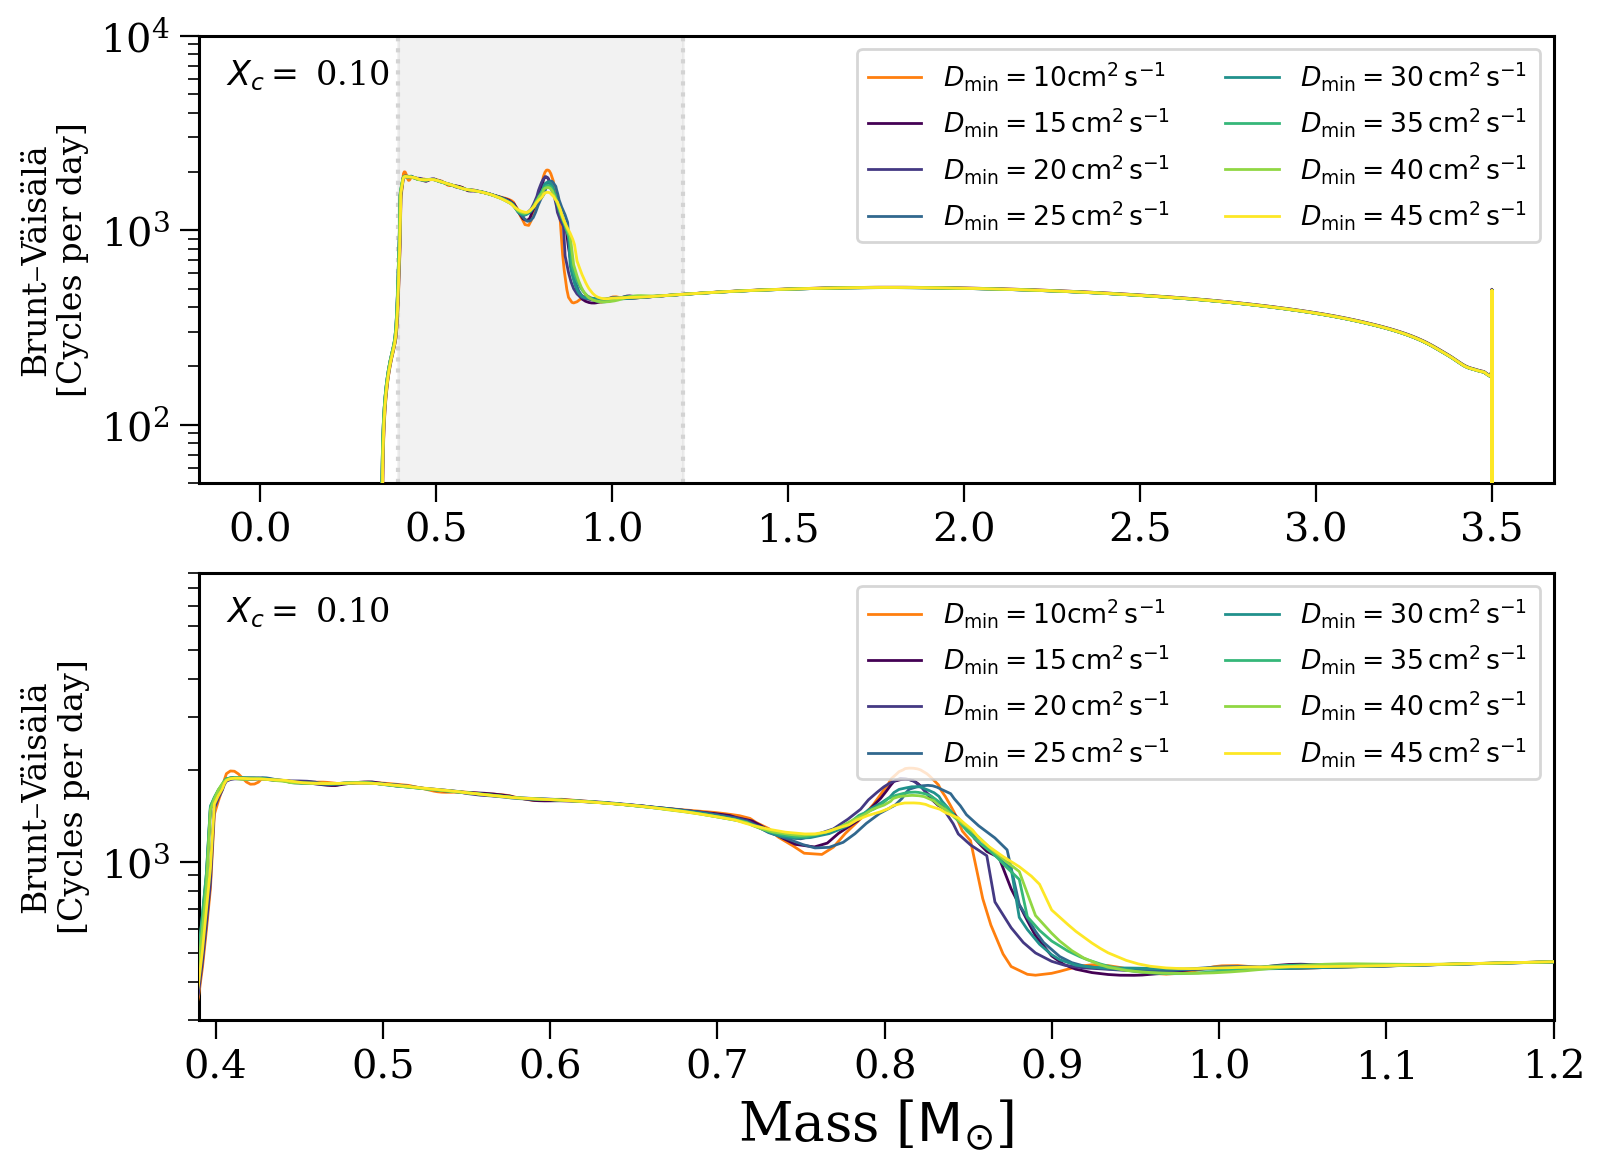

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

reverse = False

d_zoom_tracks = [tracks["4_3_5_mdm10"][1]] + [t[1] for t in list(D_mix_tracks.values())]
d_zoom_labels = [r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$"] + [t.parameters.split("(")[0] for t in [t[1] for t in list(D_mix_tracks.values())]]
d_zoom_cols = ["tab:orange"] + [plt.get_cmap("viridis", 7)(i) for i in range(7)]

if reverse:
    d_zoom_tracks = list(reversed(d_zoom_tracks))
    d_zoom_tracks = list(reversed(d_zoom_labels))
    d_zoom_tracks = list(reversed(d_zoom_cols))

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=axes[0])

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=axes[1])

fig.subplots_adjust(hspace=0.2)

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

axes[1].set_xlim(0.39, 1.2)
axes[1].set_ylim(bottom=3e2, top=9e3)
# plt.savefig("figures/min_D_mix_comparison.pdf", format="pdfs[i]s[i]s[i]s[i]", bbox_inches="tight")
plt.show()

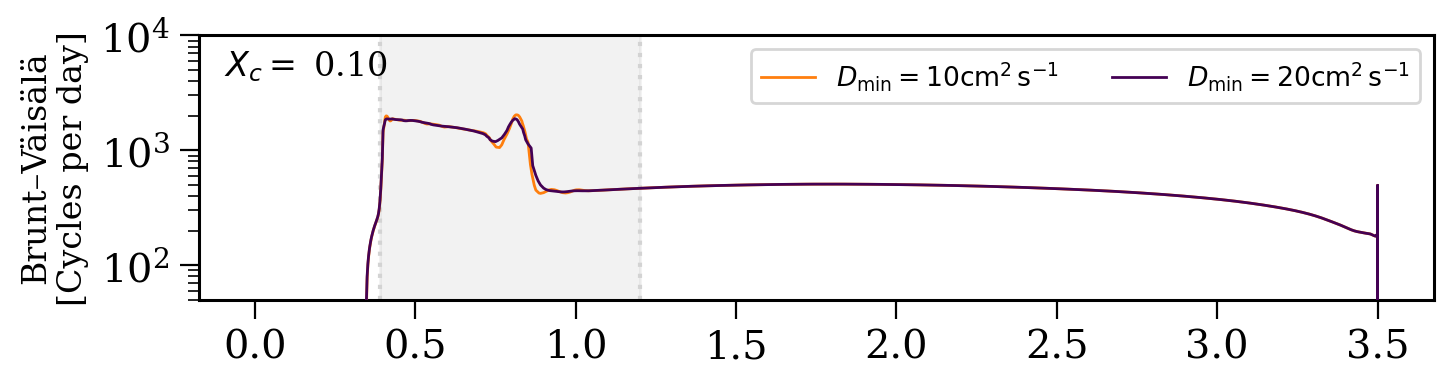

In [332]:
fig, ax = plt.subplots(figsize=(8, 3))

d_zoom_tracks = [tracks["4_3_5_mdm10"][1]] + [D_mix_tracks["D_20"][1]]
d_zoom_labels = [r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$", r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$"]
d_zoom_cols = ["tab:orange"] + [plt.get_cmap("viridis", 7)(i) for i in range(7)]

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=ax)

# fig.subplots_adjust(hspace=0.2)

axes = [ax]

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

plt.show()

## Period spacing pattern

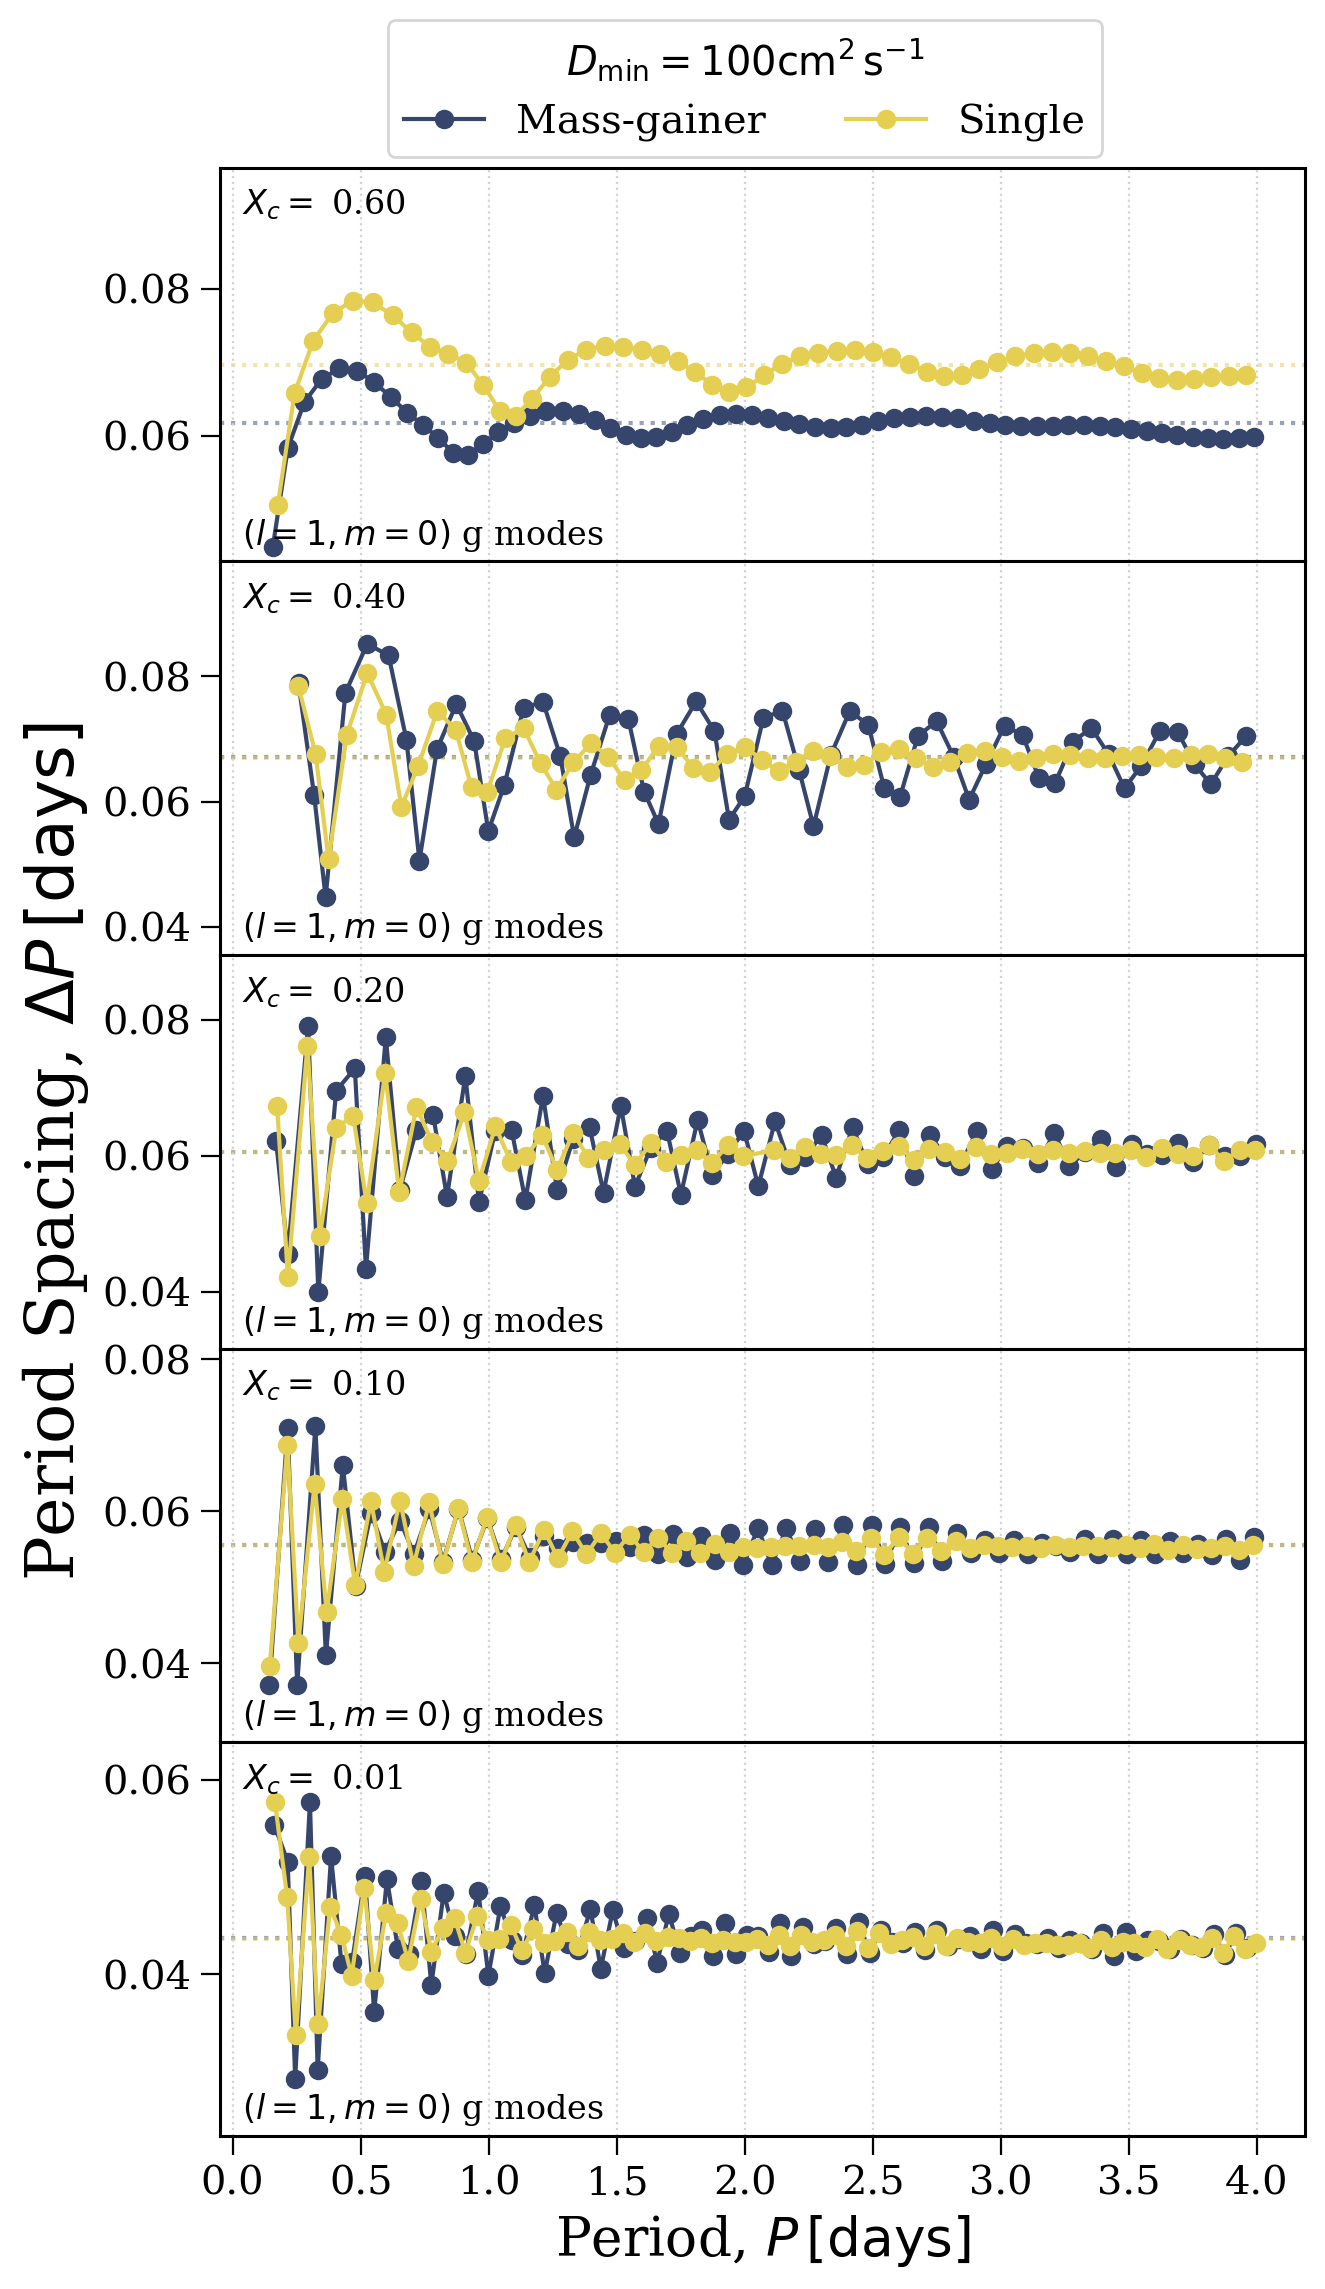

In [10]:
refresh_mpt()
fig, axes = plt.subplots(5, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip([0.6, 0.4, 0.2, 0.1, 0.01], axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]],
                            colours=[plt.get_cmap("cividis")(0.2), plt.get_cmap("cividis")(0.9)],
                            labels=["Mass-gainer", "Single"],
                            legend_loc="lower right", label_modes=False, fig=fig, ax=ax, show=False,
                            divide_delta_n=True, ylims="auto", ylim_auto_fac=1.4)
    
for ax in axes:
    ax.grid(axis='x', linestyle="dotted", color="lightgrey")
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.set_ylabel(r"Period Spacing, $\Delta P \, [\rm days]$", fontsize=fs)
    else:
        ax.set_ylabel("")

leg = fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0),
                 title=r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$")
plt.setp(leg.get_title(),fontsize=0.6*fs)

fig.subplots_adjust(hspace=0.0, top=0.93)

# plt.savefig("figures/period_spacing_mdm100.pdf", format="pdf", bbox_inches="tight")
plt.savefig("presentation_plots/period_spacing_mdm100.png", format="png", bbox_inches="tight", dpi=300)

plt.show()